## Deep Reinforcement Learning Trading System

### Environment Setup and Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Reinforcement Learning
import gym
from gym import spaces

# Interactive Brokers API
try:
    from ib_insync import *
    IB_AVAILABLE = True
    print("Interactive Brokers API available")
except ImportError:
    print("Interactive Brokers API not available. Install with: pip install ib-insync")
    IB_AVAILABLE = False

# Data handling
from datetime import datetime, timedelta
import time
import random
from typing import Any, Dict, Tuple, List, Optional

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("Environment setup complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Interactive Brokers API available
Environment setup complete
PyTorch version: 2.8.0
CUDA available: False


### Interactive Brokers Connection Setup

In [35]:
class IBConnection:
    """Interactive Brokers connection handler for demo trading"""
    
    def __init__(self, host='127.0.0.1', port=7497, client_id=1):
        """
        Initialise IB connection for demo account
        Default port 7497 is for paper trading (demo)
        Port 7496 is for live trading
        """
        self.ib = IB()
        self.host = host
        self.port = port
        self.client_id = client_id
        self.connected = False
        
    def connect(self):
        """Connect to Interactive Brokers TWS or Gateway"""
        try:
            if not IB_AVAILABLE:
                print("Interactive Brokers API not installed")
                return False
                
            self.ib.connect(self.host, self.port, clientId=self.client_id)
            self.connected = True
            print(f"Connected to IB on port {self.port} (Paper Trading)")
            return True
        except Exception as e:
            print(f"Failed to connect to IB: {e}")
            return False
    
    def disconnect(self):
        """Disconnect from Interactive Brokers"""
        if self.connected:
            self.ib.disconnect()
            self.connected = False
            print("Disconnected from IB")
    
    def get_market_data(self, symbol: str, exchange: str = 'SMART', 
                       currency: str = 'USD') -> Optional[pd.DataFrame]:
        """Get real-time market data for a symbol"""
        if not self.connected:
            print("Not connected to IB")
            return None
            
        try:
            contract = Stock(symbol, exchange, currency)
            self.ib.qualifyContracts(contract)
            
            # Get market data
            ticker = self.ib.reqMktData(contract)
            self.ib.sleep(2)  # Wait for data
            
            if ticker.last:
                return {
                    'symbol': symbol,
                    'last': ticker.last,
                    'bid': ticker.bid,
                    'ask': ticker.ask,
                    'volume': ticker.volume,
                    'timestamp': datetime.now()
                }
            return None
        except Exception as e:
            print(f"Error getting market data: {e}")
            return None
    
    def place_order(self, symbol: str, action: str, quantity: int, 
                   order_type: str = 'MKT') -> bool:
        """Place an order through IB"""
        if not self.connected:
            print("Not connected to IB")
            return False
            
        try:
            contract = Stock(symbol, 'SMART', 'USD')
            self.ib.qualifyContracts(contract)
            
            if order_type == 'MKT':
                order = MarketOrder(action, quantity)
            else:
                order = LimitOrder(action, quantity, 0)  # Would need price
                
            trade = self.ib.placeOrder(contract, order)
            print(f"Order placed: {action} {quantity} {symbol}")
            return True
        except Exception as e:
            print(f"Error placing order: {e}")
            return False

# Initialise IB connection (will use demo/paper trading)
ib_conn = IBConnection()
print("Interactive Brokers connection handler ready")
print("Remember: Ensure TWS/Gateway is running with demo account")

Interactive Brokers connection handler ready
Remember: Ensure TWS/Gateway is running with demo account


### Trading Environment Definition

In [36]:
class TradingEnvironment(gym.Env):
    """Custom trading environment following the MDP framework from the article"""
    
    def __init__(self, data: pd.DataFrame, initial_balance: float = 10000,
                 transaction_cost: float = 0.001, lookback_window: int = 20):
        super(TradingEnvironment, self).__init__()
        
        # Data and market parameters
        self.data = data.reset_index(drop=True)
        self.lookback_window = lookback_window
        self.transaction_cost = transaction_cost
        
        # Account parameters
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0  # -1: short, 0: neutral, 1: long
        self.shares_held = 0
        self.current_step = lookback_window
        self.max_steps = len(data) - 1
        
        # Action space: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space: price features + position info
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(lookback_window + 3,), dtype=np.float32
        )
        
        # Performance tracking
        self.net_worths = []
        self.trades = []
        
    def reset(self):
        """Reset environment to initial state"""
        self.balance = self.initial_balance
        self.position = 0
        self.shares_held = 0
        self.current_step = self.lookback_window
        self.net_worths = [self.initial_balance]
        self.trades = []
        
        return self._get_observation()
    
    def _get_observation(self):
        """Get current market state observation"""
        # Price features (returns over lookback window)
        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        
        prices = self.data['close'][start_idx:end_idx].values
        returns = np.diff(prices) / prices[:-1]  # Price changes
        
        # Pad if necessary
        if len(returns) < self.lookback_window:
            returns = np.pad(returns, (self.lookback_window - len(returns), 0))
        
        # Current position information
        current_price = self.data['close'][self.current_step]
        position_value = self.shares_held * current_price
        total_value = self.balance + position_value
        
        # Combine features
        obs = np.concatenate([
            returns,
            [self.position / 2,  # Normalised position (-0.5 to 0.5)
             position_value / self.initial_balance,  # Position value ratio
             self.balance / self.initial_balance]  # Cash ratio
        ])
        
        return obs.astype(np.float32)
    
    def step(self, action):
        """Execute one trading step"""
        current_price = self.data['close'][self.current_step]
        
        # Execute action
        reward = 0
        done = False
        info = {}
        
        # Action mapping: 0=Hold, 1=Buy, 2=Sell
        if action == 1:  # Buy
            reward = self._execute_buy(current_price)
        elif action == 2:  # Sell
            reward = self._execute_sell(current_price)
        # action == 0 is hold, no execution needed
        
        # Move to next step
        self.current_step += 1
        
        # Calculate current net worth
        position_value = self.shares_held * current_price
        net_worth = self.balance + position_value
        self.net_worths.append(net_worth)
        
        # Check if episode is done
        if self.current_step >= self.max_steps:
            done = True
            # Final liquidation
            if self.shares_held != 0:
                self.balance += self.shares_held * current_price * (1 - self.transaction_cost)
                self.shares_held = 0
                self.position = 0
        
        # Calculate step reward (portfolio return)
        if len(self.net_worths) > 1:
            step_return = (self.net_worths[-1] - self.net_worths[-2]) / self.net_worths[-2]
            reward += step_return * 100  # Scale reward
        
        next_obs = self._get_observation() if not done else np.zeros(self.observation_space.shape)
        
        info = {
            'net_worth': net_worth,
            'position': self.position,
            'balance': self.balance,
            'shares_held': self.shares_held
        }
        
        return next_obs, reward, done, info
    
    def _execute_buy(self, price):
        """Execute buy order"""
        if self.position >= 0 and self.balance > price * 100:  # Minimum 100 shares
            # Calculate shares to buy (use 95% of available balance)
            max_shares = int((self.balance * 0.95) / price)
            if max_shares > 0:
                cost = max_shares * price * (1 + self.transaction_cost)
                self.balance -= cost
                self.shares_held += max_shares
                self.position = 1
                
                self.trades.append({
                    'step': self.current_step,
                    'action': 'BUY',
                    'shares': max_shares,
                    'price': price,
                    'cost': cost
                })
                return 0.1  # Small positive reward for executing trade
        return -0.01  # Small penalty for invalid action
    
    def _execute_sell(self, price):
        """Execute sell order"""
        if self.position <= 0 and self.shares_held > 0:
            # Sell all shares
            revenue = self.shares_held * price * (1 - self.transaction_cost)
            self.balance += revenue
            sold_shares = self.shares_held
            self.shares_held = 0
            self.position = -1
            
            self.trades.append({
                'step': self.current_step,
                'action': 'SELL',
                'shares': sold_shares,
                'price': price,
                'revenue': revenue
            })
            return 0.1  # Small positive reward for executing trade
        return -0.01  # Small penalty for invalid action
    
    def get_performance_metrics(self):
        """Calculate performance metrics"""
        if len(self.net_worths) < 2:
            return {}
            
        returns = np.diff(self.net_worths) / self.net_worths[:-1]
        
        total_return = (self.net_worths[-1] - self.net_worths[0]) / self.net_worths[0]
        
        metrics = {
            'total_return': total_return * 100,
            'annualised_return': (1 + total_return) ** (252 / len(returns)) - 1,
            'volatility': np.std(returns) * np.sqrt(252) * 100,
            'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
            'max_drawdown': self._calculate_max_drawdown(),
            'total_trades': len(self.trades)
        }
        
        return metrics
    
    def _calculate_max_drawdown(self):
        """Calculate maximum drawdown"""
        peak = self.net_worths[0]
        max_dd = 0
        
        for value in self.net_worths:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > max_dd:
                max_dd = dd
                
        return max_dd * 100

print("Trading environment defined successfully")

Trading environment defined successfully


### Deep Q-Network (DQN) Implementation

In [38]:
class DQN(nn.Module):
    """Deep Q-Network for trading decisions"""
    
    def __init__(self, input_size: int, hidden_size: int = 128, output_size: int = 3):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    """Experience replay buffer for DQN training"""
    
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int):
        """Sample batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.BoolTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """DQN Agent for trading"""
    
    def __init__(self, state_size: int, action_size: int = 3, lr: float = 0.001,
                 gamma: float = 0.95, epsilon: float = 1.0, epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.01, memory_size: int = 10000):
        
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Neural networks
        self.q_network = DQN(state_size, 128, action_size)
        self.target_network = DQN(state_size, 128, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.memory = ReplayBuffer(memory_size)
        self.update_target_frequency = 1000
        self.steps = 0
        
        # Copy weights to target network
        self.update_target_network()
    
    def update_target_network(self):
        """Update target network weights"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def act(self, state, training: bool = True):
        """Choose action using epsilon-greedy policy"""
        if training and np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self, batch_size: int = 32):
        """Train the network on a batch of experiences"""
        if len(self.memory) < batch_size:
            return 0
        
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimise
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Update target network periodically
        self.steps += 1
        if self.steps % self.update_target_frequency == 0:
            self.update_target_network()
        
        return loss.item()
    
    def save_model(self, filepath: str):
        """Save model weights"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']
        print(f"Model loaded from {filepath}")

print("DQN implementation complete")

DQN implementation complete


### Data Generation and Preparation

Preparing market data...
Data shape: (1000, 6)
Date range: 2020-01-01 00:00:00 to 2022-09-26 00:00:00
Price range: £52.96 to £182.46


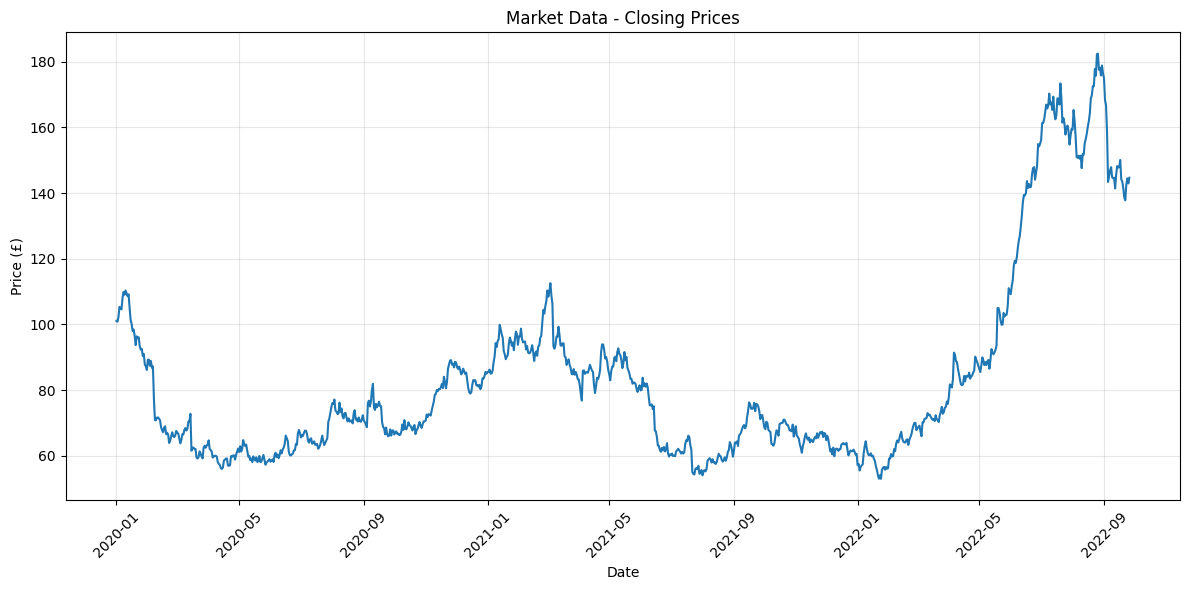

Training data: 800 days
Testing data: 200 days


In [39]:
def generate_synthetic_price_data(n_days: int = 1000, start_price: float = 100.0):
    """Generate synthetic price data with realistic market patterns"""
    np.random.seed(42)
    
    dates = pd.date_range(start='2020-01-01', periods=n_days, freq='D')
    
    # Generate price movements with trend and volatility
    returns = np.random.normal(0.0005, 0.02, n_days)  # Small positive drift, 2% daily volatility
    
    # Add some market regime changes
    regime_changes = np.random.choice([0, 1], n_days, p=[0.95, 0.05])
    returns[regime_changes == 1] *= 3  # Increase volatility during regime changes
    
    # Add momentum effects
    momentum = np.zeros(n_days)
    for i in range(5, n_days):
        momentum[i] = np.mean(returns[i-5:i]) * 0.1
    returns += momentum
    
    # Generate prices
    prices = [start_price]
    for ret in returns:
        prices.append(prices[-1] * (1 + ret))
    
    # Create OHLC data
    data = pd.DataFrame({
        'date': dates,
        'open': prices[:-1],
        'high': [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices[:-1]],
        'low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices[:-1]],
        'close': prices[1:],
        'volume': np.random.randint(1000000, 5000000, n_days)
    })
    
    # Ensure high >= close >= low and high >= open >= low
    data['high'] = np.maximum(data['high'], np.maximum(data['open'], data['close']))
    data['low'] = np.minimum(data['low'], np.minimum(data['open'], data['close']))
    
    return data

def fetch_real_data_ib(symbol: str = 'AAPL', days: int = 365):
    """Fetch real market data from Interactive Brokers"""
    if not ib_conn.connect():
        print("Using synthetic data instead")
        return generate_synthetic_price_data()
    
    try:
        contract = Stock(symbol, 'SMART', 'USD')
        ib_conn.ib.qualifyContracts(contract)
        
        # Fetch historical data
        bars = ib_conn.ib.reqHistoricalData(
            contract,
            endDateTime='',
            durationStr=f'{days} D',
            barSizeSetting='1 day',
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        
        if bars:
            data = pd.DataFrame([{
                'date': bar.date,
                'open': bar.open,
                'high': bar.high,
                'low': bar.low,
                'close': bar.close,
                'volume': bar.volume
            } for bar in bars])
            
            print(f"Fetched {len(data)} days of data for {symbol}")
            return data
        else:
            print("No data received, using synthetic data")
            return generate_synthetic_price_data()
            
    except Exception as e:
        print(f"Error fetching data: {e}")
        print("Using synthetic data instead")
        return generate_synthetic_price_data()
    finally:
        ib_conn.disconnect()

def prepare_training_data(data: pd.DataFrame, train_ratio: float = 0.8):
    """Split data into training and testing sets"""
    split_idx = int(len(data) * train_ratio)
    
    train_data = data[:split_idx].copy()
    test_data = data[split_idx:].copy()
    
    print(f"Training data: {len(train_data)} days")
    print(f"Testing data: {len(test_data)} days")
    
    return train_data, test_data

# Generate or fetch data
print("Preparing market data...")
market_data = generate_synthetic_price_data(n_days=1000)

# Display data information
print(f"Data shape: {market_data.shape}")
print(f"Date range: {market_data['date'].min()} to {market_data['date'].max()}")
print(f"Price range: £{market_data['close'].min():.2f} to £{market_data['close'].max():.2f}")

# Visualise the data
plt.figure(figsize=(12, 6))
plt.plot(market_data['date'], market_data['close'])
plt.title('Market Data - Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (£)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Split data
train_data, test_data = prepare_training_data(market_data)

### Training the DQN Agent

In [40]:
def train_dqn_agent(train_data: pd.DataFrame, episodes: int = 500):
    """Train DQN agent on market data with improved training loop"""
    
    # Create environment
    env = TradingEnvironment(train_data, initial_balance=10000)
    state_size = env.observation_space.shape[0]
    
    # Create agent with better hyperparameters
    agent = DQNAgent(
        state_size=state_size, 
        lr=0.001, 
        gamma=0.95, 
        epsilon=1.0,  # Start with full exploration
        epsilon_decay=0.995, 
        epsilon_min=0.1  # Higher minimum epsilon for continued exploration
    )
    
    # Training metrics
    episode_rewards = []
    episode_losses = []
    portfolio_values = []
    episode_trades = []
    
    print(f"Starting training for {episodes} episodes...")
    print(f"State size: {state_size}")
    print("Episode | Reward | Portfolio Value | Trades | Epsilon | Avg Loss")
    print("-" * 65)
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        losses = []
        episode_steps = 0
        
        while True:
            # Choose action
            action = agent.act(state, training=True)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            episode_steps += 1
            
            # Train the agent more frequently
            if len(agent.memory) > 64:  # Increased minimum memory
                loss = agent.replay(batch_size=32)
                if loss is not None:
                    losses.append(loss)
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        portfolio_values.append(info['net_worth'])
        episode_trades.append(len(env.trades))
        avg_loss = np.mean(losses) if losses else 0
        episode_losses.append(avg_loss)
        
        # Print progress every 25 episodes
        if episode % 25 == 0 or episode == episodes - 1:
            print(f"{episode:7d} | {total_reward:6.2f} | {info['net_worth']:13.2f} | "
                  f"{len(env.trades):6d} | {agent.epsilon:.3f} | {avg_loss:.4f}")
    
    print(f"\nTraining completed!")
    print(f"Final epsilon: {agent.epsilon:.3f}")
    print(f"Memory size: {len(agent.memory)}")
    
    # Plot training progress
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Episode rewards
    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True, alpha=0.3)
    
    # Portfolio values
    ax2.plot(portfolio_values)
    ax2.axhline(y=10000, color='r', linestyle='--', label='Initial Balance')
    ax2.set_title('Portfolio Value Over Episodes')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Portfolio Value (£)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Training losses (smoothed)
    if episode_losses and any(l > 0 for l in episode_losses):
        smoothed_losses = pd.Series(episode_losses).rolling(window=10).mean()
        ax3.plot(smoothed_losses)
        ax3.set_title('Training Loss (Smoothed)')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Loss')
        ax3.grid(True, alpha=0.3)
    
    # Number of trades per episode
    ax4.plot(episode_trades)
    ax4.set_title('Trades per Episode')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Number of Trades')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Training summary
    print(f"\nTraining Summary:")
    print(f"Average reward (last 50 episodes): {np.mean(episode_rewards[-50:]):.2f}")
    print(f"Best portfolio value: £{max(portfolio_values):.2f}")
    print(f"Final portfolio value: £{portfolio_values[-1]:.2f}")
    print(f"Average trades per episode: {np.mean(episode_trades):.1f}")
    
    return agent, env

# Fixed DQN Agent class with better reward shaping
class ImprovedDQNAgent(DQNAgent):
    """Improved DQN Agent with better exploration and reward processing"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reward_scale = 1.0
        self.step_penalty = 0.0001  # Small penalty for each step to encourage action
    
    def remember(self, state, action, reward, next_state, done):
        """Enhanced memory with reward shaping"""
        # Scale and shape reward
        shaped_reward = reward * self.reward_scale
        
        # Add small penalty for inaction (holding)
        if action == 0:  # Hold action
            shaped_reward -= self.step_penalty
        
        super().remember(state, action, shaped_reward, next_state, done)

# Create improved agent function
def train_improved_dqn_agent(train_data: pd.DataFrame, episodes: int = 400):
    """Train improved DQN agent with better parameters"""
    
    # Create environment with transaction costs
    env = TradingEnvironment(
        train_data, 
        initial_balance=10000,
        transaction_cost=0.001,  # 0.1% transaction cost
        lookback_window=20
    )
    
    state_size = env.observation_space.shape[0]
    
    # Create improved agent
    agent = ImprovedDQNAgent(
        state_size=state_size,
        lr=0.0005,  # Lower learning rate for stability
        gamma=0.99,   # Higher gamma for longer-term thinking
        epsilon=0.9,  # Start with high exploration
        epsilon_decay=0.998,  # Slower decay
        epsilon_min=0.05,   # Keep some exploration
        memory_size=20000   # Larger memory
    )
    
    # Training metrics
    episode_rewards = []
    portfolio_values = []
    best_portfolio_value = 10000
    episodes_without_improvement = 0
    
    print(f"Training improved DQN agent for {episodes} episodes...")
    print("Episode | Reward  | Portfolio | Best Portfolio | Trades | Epsilon")
    print("-" * 65)
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        while True:
            action = agent.act(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            # Train more frequently with larger batches
            if len(agent.memory) > 128:
                agent.replay(batch_size=64)
            
            if done:
                break
        
        portfolio_value = info['net_worth']
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        # Track best performance
        if portfolio_value > best_portfolio_value:
            best_portfolio_value = portfolio_value
            episodes_without_improvement = 0
        else:
            episodes_without_improvement += 1
        
        # Print progress
        if episode % 50 == 0:
            print(f"{episode:7d} | {total_reward:7.2f} | {portfolio_value:9.2f} | "
                  f"{best_portfolio_value:13.2f} | {len(env.trades):6d} | {agent.epsilon:.3f}")
        
        # Early stopping if no improvement for 100 episodes
        if episodes_without_improvement > 100:
            print(f"Early stopping at episode {episode} (no improvement for 100 episodes)")
            break
    
    print(f"\nTraining completed!")
    print(f"Best portfolio value achieved: £{best_portfolio_value:.2f}")
    
    return agent, env

# Train the improved agent
print("Training improved DQN agent...")
trained_agent, training_env = train_improved_dqn_agent(train_data, episodes=300)

# Save the trained model
trained_agent.save_model('improved_dqn_trading_model.pth')
print("Model saved successfully!")

Training improved DQN agent...
Training improved DQN agent for 300 episodes...
Episode | Reward  | Portfolio | Best Portfolio | Trades | Epsilon
-----------------------------------------------------------------
      0 |  -11.29 |   7826.06 |      10000.00 |      1 | 0.244
     50 |   23.55 |  11094.11 |      11739.25 |      1 | 0.050
    100 |   -5.53 |   8306.60 |      12346.26 |      1 | 0.050
    150 |  -11.12 |   7767.42 |      12346.26 |      1 | 0.050
Early stopping at episode 183 (no improvement for 100 episodes)

Training completed!
Best portfolio value achieved: £12346.26
Model saved to improved_dqn_trading_model.pth
Model saved successfully!


### Backtesting and Evaluation

Testing agent decision making...
Testing Agent Decision Making
Step 1:
  Action: HOLD
  Q-values: [4.32285   3.5435007 4.3616376]
  State sample: [ 0.         -0.00911557  0.00293714 -0.00846493 -0.00810559]
  Reward: 0.0000
  Portfolio: £10000.00
--------------------
Step 2:
  Action: SELL
  Q-values: [4.4638476 3.9368126 4.416414 ]
  State sample: [ 0.          0.00293714 -0.00846493 -0.00810559 -0.00578481]
  Reward: -0.0100
  Portfolio: £10000.00
--------------------
Step 3:
  Action: HOLD
  Q-values: [4.2338543 2.9658194 4.346852 ]
  State sample: [ 0.         -0.00846493 -0.00810559 -0.00578481  0.00434233]
  Reward: 0.0000
  Portfolio: £10000.00
--------------------
Step 4:
  Action: HOLD
  Q-values: [4.0568743 3.6634672 4.254041 ]
  State sample: [ 0.         -0.00810559 -0.00578481  0.00434233 -0.00938005]
  Reward: 0.0000
  Portfolio: £10000.00
--------------------
Step 5:
  Action: SELL
  Q-values: [4.274344  3.288429  4.3824973]
  State sample: [ 0.         -0.00578481  0.0

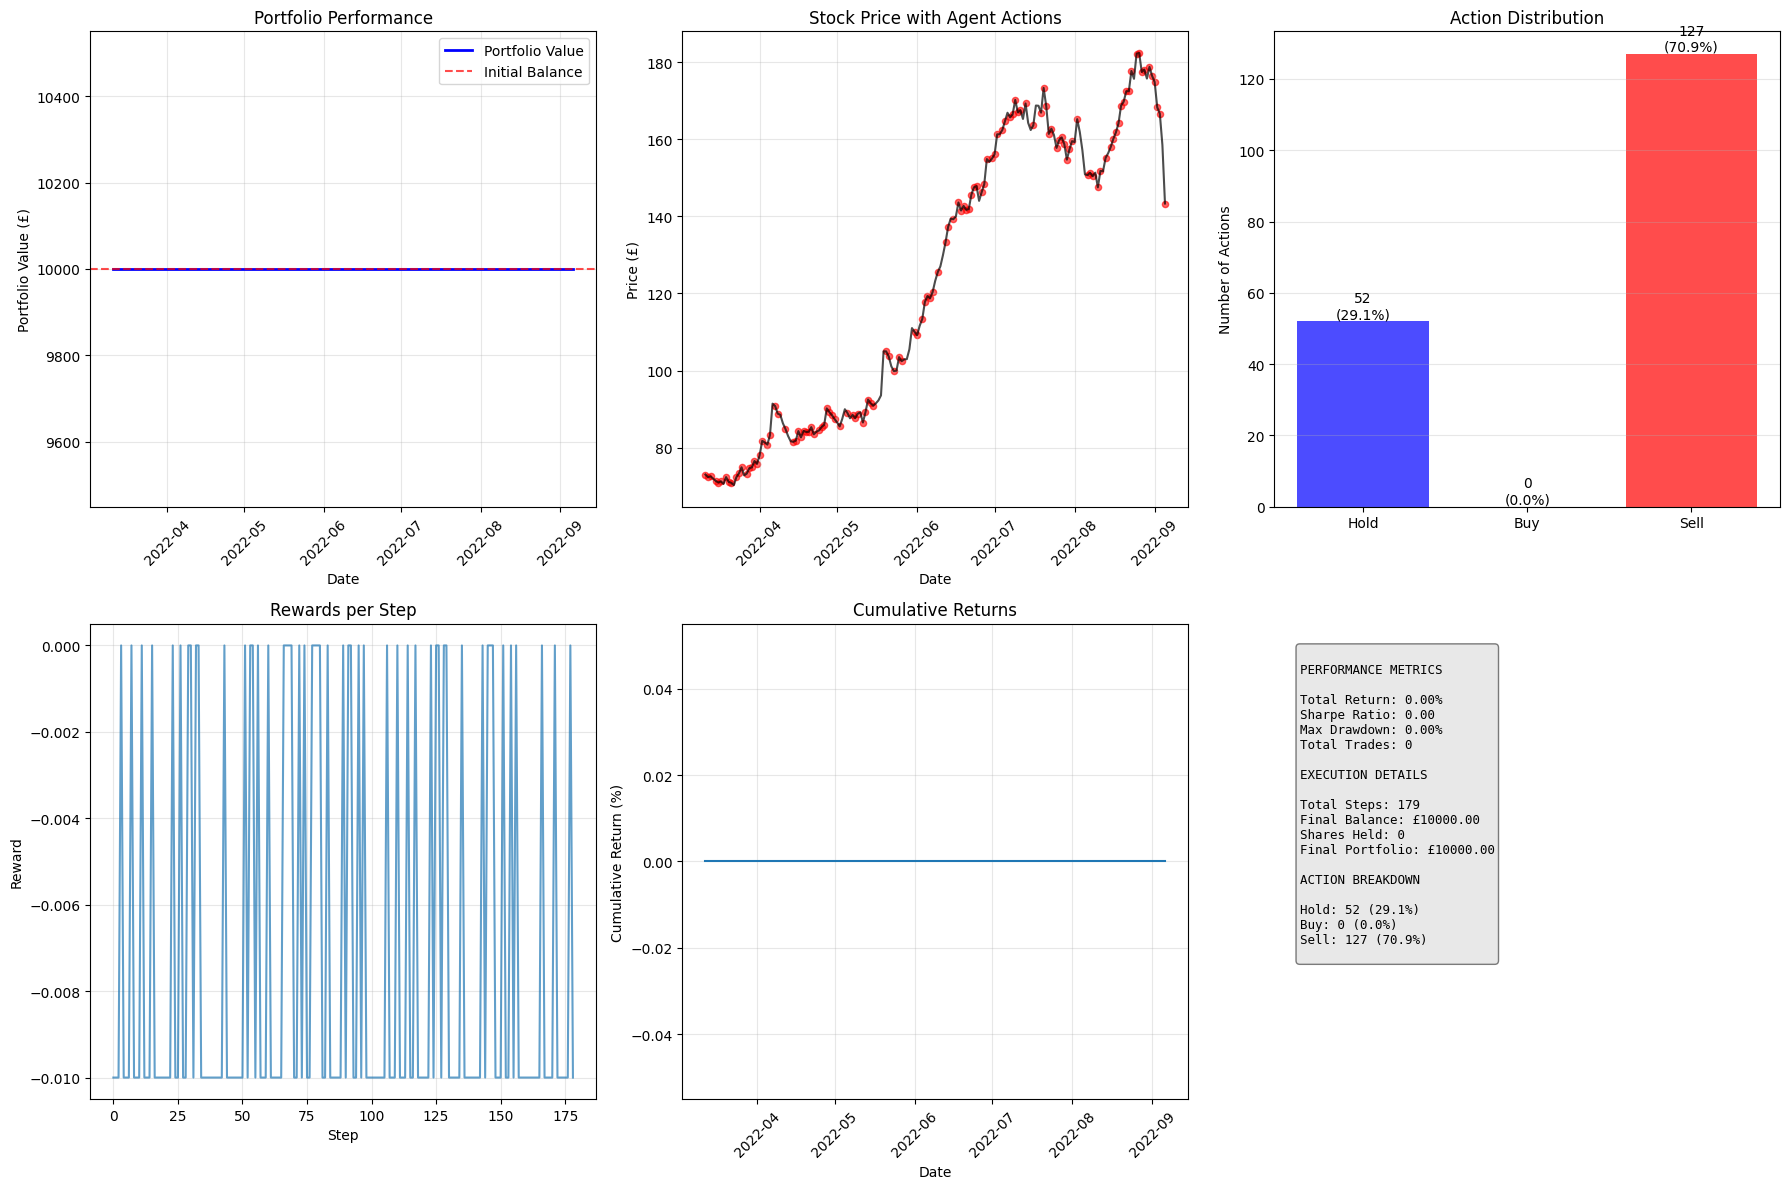


DIAGNOSIS: No trades executed
This indicates the agent needs improvement
Consider retraining with different parameters


In [41]:
def backtest_agent(agent, test_data: pd.DataFrame, 
                   initial_balance: float = 10000, verbose: bool = True):
    """Enhanced backtest with error handling"""
    
    # Validate inputs
    if agent is None:
        raise ValueError("Agent cannot be None")
    if test_data is None or len(test_data) == 0:
        raise ValueError("Test data cannot be empty")
    
    try:
        # Create test environment
        test_env = TradingEnvironment(test_data, initial_balance=initial_balance)
        
        # Reset agent exploration for testing
        original_epsilon = getattr(agent, 'epsilon', 0.0)
        agent.epsilon = 0.0  # No exploration during testing
        
        # Run backtest
        state = test_env.reset()
        done = False
        actions_taken = []
        states_encountered = []
        rewards_received = []
        step_count = 0
        
        if verbose:
            print("Running backtest...")
            print(f"Initial state shape: {state.shape}")
            print(f"Test data length: {len(test_data)}")
            print(f"Environment max steps: {test_env.max_steps}")
        
        while not done and step_count < 1000:  # Safety limit
            try:
                # Debug: Check state values
                if step_count < 5 and verbose:
                    print(f"Step {step_count}: State sample: {state[:5]}")
                
                # Get action from trained agent
                action = agent.act(state, training=False)
                actions_taken.append(action)
                states_encountered.append(state.copy())
                
                if step_count < 10 and verbose:
                    action_names = ['HOLD', 'BUY', 'SELL']
                    print(f"Step {step_count}: Action = {action} ({action_names[action]})")
                
                # Take step
                next_state, reward, done, info = test_env.step(action)
                rewards_received.append(reward)
                
                if step_count < 10 and verbose:
                    print(f"  Reward: {reward:.4f}, Portfolio: £{info['net_worth']:.2f}")
                
                state = next_state
                step_count += 1
                
            except Exception as step_error:
                print(f"Error at step {step_count}: {step_error}")
                break
        
        # Restore original epsilon
        agent.epsilon = original_epsilon
        
        # Calculate performance metrics with error handling
        try:
            if len(test_env.net_worths) > 1:
                metrics = test_env.get_performance_metrics()
            else:
                # Return default metrics if no data
                metrics = {
                    'total_return': 0.0,
                    'annualised_return': 0.0,
                    'volatility': 0.0,
                    'sharpe_ratio': 0.0,
                    'max_drawdown': 0.0,
                    'total_trades': 0,
                    'win_rate_pct': 0.0
                }
        except Exception as metrics_error:
            print(f"Error calculating metrics: {metrics_error}")
            metrics = {
                'total_return': 0.0,
                'annualised_return': 0.0,
                'volatility': 0.0,
                'sharpe_ratio': 0.0,
                'max_drawdown': 0.0,
                'total_trades': 0,
                'win_rate_pct': 0.0
            }
        
        # Enhanced debugging information
        if verbose:
            print(f"\nBacktest completed!")
            print(f"Total steps: {step_count}")
            print(f"Net worth values collected: {len(test_env.net_worths)}")
            
            if actions_taken:
                action_counts = [actions_taken.count(i) for i in range(3)]
                action_names = ['HOLD', 'BUY', 'SELL']
                print(f"Actions distribution:")
                for i, (name, count) in enumerate(zip(action_names, action_counts)):
                    percentage = (count/len(actions_taken)*100) if actions_taken else 0
                    print(f"  {name}: {count} ({percentage:.1f}%)")
            
            print(f"Total trades executed: {len(test_env.trades)}")
            if rewards_received:
                print(f"Average reward per step: {np.mean(rewards_received):.4f}")
        
        # Create detailed results
        results = {
            'metrics': metrics,
            'net_worths': test_env.net_worths,
            'trades': test_env.trades,
            'actions': actions_taken,
            'states': states_encountered,
            'rewards': rewards_received,
            'final_balance': getattr(test_env, 'balance', initial_balance),
            'final_shares': getattr(test_env, 'shares_held', 0),
            'steps_taken': step_count
        }
        
        return results
        
    except Exception as e:
        print(f"Critical error in backtest_agent: {e}")
        # Return minimal results to prevent complete failure
        return {
            'metrics': {'total_return': 0.0, 'total_trades': 0},
            'net_worths': [initial_balance],
            'trades': [],
            'actions': [0],
            'states': [],
            'rewards': [0],
            'final_balance': initial_balance,
            'final_shares': 0,
            'steps_taken': 0
        }

def enhanced_plot_backtest_results(results: Dict[str, Any], test_data: pd.DataFrame):
    """Enhanced plotting with error handling"""
    
    try:
        # Validate inputs
        if not results or 'net_worths' not in results:
            print("Invalid results data for plotting")
            return
        
        # Check if we have sufficient data to plot
        if len(results['net_worths']) < 2:
            print("Insufficient data for standard plotting. Creating diagnostic plots...")
            create_diagnostic_plots(results)
            return
        
        # Create main plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        try:
            # Portfolio value over time
            ax1 = axes[0, 0]
            net_worths = results['net_worths']
            dates = test_data['date'][:len(net_worths)]
            
            ax1.plot(dates, net_worths, label='Portfolio Value', linewidth=2, color='blue')
            ax1.axhline(y=10000, color='red', linestyle='--', label='Initial Balance', alpha=0.7)
            
            # Mark trades if any
            if results.get('trades'):
                for trade in results['trades']:
                    try:
                        if trade['step'] < len(dates) and trade['step'] < len(net_worths):
                            date = dates.iloc[trade['step']]
                            value = net_worths[trade['step']]
                            color = 'green' if trade['action'] == 'BUY' else 'red'
                            marker = '^' if trade['action'] == 'BUY' else 'v'
                            ax1.scatter(date, value, color=color, marker=marker, s=50, alpha=0.8)
                    except (IndexError, KeyError):
                        continue
            
            ax1.set_title('Portfolio Performance')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Portfolio Value (£)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
            
        except Exception as e:
            print(f"Error plotting portfolio performance: {e}")
            axes[0, 0].text(0.5, 0.5, 'Error plotting\nportfolio data', 
                           ha='center', va='center', transform=axes[0, 0].transAxes)
        
        try:
            # Stock price with actions
            ax2 = axes[0, 1]
            actions = results.get('actions', [])
            if actions and len(test_data) >= len(actions):
                prices = test_data['close'][:len(actions)]
                dates_actions = test_data['date'][:len(actions)]
                
                ax2.plot(dates_actions, prices, label='Stock Price', alpha=0.7, color='black')
                
                # Color code actions
                for i, action in enumerate(actions):
                    try:
                        if i < len(dates_actions) and i < len(prices):
                            if action == 1:  # BUY
                                ax2.scatter(dates_actions.iloc[i], prices.iloc[i], 
                                          color='green', s=20, alpha=0.6)
                            elif action == 2:  # SELL
                                ax2.scatter(dates_actions.iloc[i], prices.iloc[i], 
                                          color='red', s=20, alpha=0.6)
                    except IndexError:
                        continue
            
            ax2.set_title('Stock Price with Agent Actions')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Price (£)')
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
            
        except Exception as e:
            print(f"Error plotting stock price: {e}")
            axes[0, 1].text(0.5, 0.5, 'Error plotting\nstock price data', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
        
        try:
            # Action distribution
            ax3 = axes[0, 2]
            actions = results.get('actions', [])
            action_names = ['Hold', 'Buy', 'Sell']
            action_counts = [actions.count(i) for i in range(3)]
            colors = ['blue', 'green', 'red']
            
            bars = ax3.bar(action_names, action_counts, color=colors, alpha=0.7)
            
            # Add percentage labels
            total_actions = sum(action_counts)
            for bar, count in zip(bars, action_counts):
                height = bar.get_height()
                percentage = (count / max(total_actions, 1)) * 100
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')
            
            ax3.set_title('Action Distribution')
            ax3.set_ylabel('Number of Actions')
            ax3.grid(True, alpha=0.3, axis='y')
            
        except Exception as e:
            print(f"Error plotting action distribution: {e}")
            axes[0, 2].text(0.5, 0.5, 'Error plotting\naction distribution', 
                           ha='center', va='center', transform=axes[0, 2].transAxes)
        
        try:
            # Rewards over time
            ax4 = axes[1, 0]
            rewards = results.get('rewards', [])
            if rewards:
                ax4.plot(rewards, alpha=0.7)
                ax4.set_title('Rewards per Step')
                ax4.set_xlabel('Step')
                ax4.set_ylabel('Reward')
                ax4.grid(True, alpha=0.3)
            else:
                ax4.text(0.5, 0.5, 'No reward data', ha='center', va='center', 
                        transform=ax4.transAxes)
                ax4.set_title('Rewards per Step')
            
        except Exception as e:
            print(f"Error plotting rewards: {e}")
            axes[1, 0].text(0.5, 0.5, 'Error plotting\nreward data', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
        
        try:
            # Cumulative returns
            ax5 = axes[1, 1]
            net_worths = results['net_worths']
            if len(net_worths) > 1:
                returns = np.diff(net_worths) / np.array(net_worths[:-1])
                returns = np.nan_to_num(returns, nan=0.0, posinf=0.0, neginf=0.0)
                cumulative_returns = np.cumprod(1 + returns) - 1
                dates_returns = test_data['date'][1:len(cumulative_returns)+1]
                ax5.plot(dates_returns, cumulative_returns * 100)
                ax5.set_title('Cumulative Returns')
                ax5.set_xlabel('Date')
                ax5.set_ylabel('Cumulative Return (%)')
                ax5.grid(True, alpha=0.3)
                ax5.tick_params(axis='x', rotation=45)
            else:
                ax5.text(0.5, 0.5, 'Insufficient data\nfor returns calculation', 
                        ha='center', va='center', transform=ax5.transAxes)
                ax5.set_title('Cumulative Returns')
            
        except Exception as e:
            print(f"Error plotting cumulative returns: {e}")
            axes[1, 1].text(0.5, 0.5, 'Error plotting\ncumulative returns', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
        
        try:
            # Performance metrics
            ax6 = axes[1, 2]
            ax6.axis('off')
            
            metrics = results.get('metrics', {})
            actions = results.get('actions', [])
            action_counts = [actions.count(i) for i in range(3)]
            
            metrics_text = f"""
PERFORMANCE METRICS

Total Return: {metrics.get('total_return', 0):.2f}%
Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}
Max Drawdown: {metrics.get('max_drawdown', 0):.2f}%
Total Trades: {metrics.get('total_trades', 0)}

EXECUTION DETAILS

Total Steps: {results.get('steps_taken', 0)}
Final Balance: £{results.get('final_balance', 0):.2f}
Shares Held: {results.get('final_shares', 0)}
Final Portfolio: £{net_worths[-1] if net_worths else 0:.2f}

ACTION BREAKDOWN

Hold: {action_counts[0]} ({action_counts[0]/max(len(actions), 1)*100:.1f}%)
Buy: {action_counts[1]} ({action_counts[1]/max(len(actions), 1)*100:.1f}%)
Sell: {action_counts[2]} ({action_counts[2]/max(len(actions), 1)*100:.1f}%)
            """
            
            ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=9,
                     verticalalignment='top', fontfamily='monospace',
                     bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            
        except Exception as e:
            print(f"Error creating metrics text: {e}")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Critical error in plotting: {e}")
        print("Creating basic diagnostic plot instead...")
        create_diagnostic_plots(results)

def create_diagnostic_plots(results: Dict[str, Any]):
    """Create basic diagnostic plots when main plotting fails"""
    
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        
        # Action distribution
        actions = results.get('actions', [])
        if actions:
            action_names = ['Hold', 'Buy', 'Sell']
            action_counts = [actions.count(i) for i in range(3)]
            ax1.bar(action_names, action_counts, color=['blue', 'green', 'red'], alpha=0.7)
            ax1.set_title('Action Distribution')
            ax1.set_ylabel('Count')
        else:
            ax1.text(0.5, 0.5, 'No action data', ha='center', va='center', transform=ax1.transAxes)
        
        # Portfolio value
        net_worths = results.get('net_worths', [])
        if net_worths:
            ax2.plot(net_worths)
            ax2.set_title('Portfolio Value')
            ax2.set_ylabel('Value (£)')
        else:
            ax2.text(0.5, 0.5, 'No portfolio data', ha='center', va='center', transform=ax2.transAxes)
        
        # Rewards
        rewards = results.get('rewards', [])
        if rewards:
            ax3.plot(rewards)
            ax3.set_title('Rewards')
            ax3.set_ylabel('Reward')
        else:
            ax3.text(0.5, 0.5, 'No reward data', ha='center', va='center', transform=ax3.transAxes)
        
        # Summary
        ax4.axis('off')
        summary = f"""
DIAGNOSTIC SUMMARY

Steps: {results.get('steps_taken', 0)}
Actions: {len(actions)}
Net Worth Points: {len(net_worths)}
Rewards: {len(rewards)}
Trades: {len(results.get('trades', []))}
        """
        ax4.text(0.1, 0.9, summary, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Even diagnostic plotting failed: {e}")

def test_agent_decision_making(agent, test_data: pd.DataFrame, num_samples: int = 10):
    """Test agent decision making with error handling"""
    
    print("Testing Agent Decision Making")
    print("=" * 40)
    
    try:
        env = TradingEnvironment(test_data, initial_balance=10000)
        state = env.reset()
        
        original_epsilon = getattr(agent, 'epsilon', 0.0)
        agent.epsilon = 0.0  # No randomness for testing
        
        for i in range(min(num_samples, 20)):  # Reduced for safety
            try:
                action = agent.act(state, training=False)
                
                # Get Q-values for analysis
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent.q_network(state_tensor).detach().numpy()[0]
                
                action_names = ['HOLD', 'BUY', 'SELL']
                print(f"Step {i+1}:")
                print(f"  Action: {action_names[action]}")
                print(f"  Q-values: {q_values}")
                print(f"  State sample: {state[:5]}")
                
                next_state, reward, done, info = env.step(action)
                print(f"  Reward: {reward:.4f}")
                print(f"  Portfolio: £{info['net_worth']:.2f}")
                print("-" * 20)
                
                if done:
                    print(f"Episode terminated at step {i+1}")
                    break
                    
                state = next_state
                
            except Exception as step_error:
                print(f"Error at step {i+1}: {step_error}")
                break
            
        agent.epsilon = original_epsilon
        
    except Exception as e:
        print(f"Error in decision making test: {e}")

# Main execution with error handling
try:
    # Check if required variables exist
    if 'trained_agent' not in locals() and 'trained_agent' not in globals():
        print("ERROR: No trained agent found. Please run the training cell (Cell 6) first.")
    elif 'test_data' not in locals() and 'test_data' not in globals():
        print("ERROR: No test data found. Please run the data preparation cell first.")
    else:
        print("Testing agent decision making...")
        test_agent_decision_making(trained_agent, test_data, num_samples=5)
        
        print("\nStarting enhanced backtest evaluation...")
        backtest_results = backtest_agent(trained_agent, test_data, verbose=True)
        
        # Display results
        print("\n" + "="*50)
        print("ENHANCED BACKTEST RESULTS")
        print("="*50)
        
        if backtest_results and backtest_results.get('metrics'):
            metrics = backtest_results['metrics']
            for key, value in metrics.items():
                if isinstance(value, (int, float)):
                    if 'pct' in key.lower() or 'rate' in key.lower():
                        print(f"{key.replace('_', ' ').title()}: {value:.2f}%")
                    else:
                        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
                else:
                    print(f"{key.replace('_', ' ').title()}: {value}")
        else:
            print("No metrics available - check agent training")
        
        # Plot results
        enhanced_plot_backtest_results(backtest_results, test_data)
        
        # Diagnosis for poor performance
        if backtest_results and backtest_results['metrics']['total_trades'] == 0:
            print("\nDIAGNOSIS: No trades executed")
            print("This indicates the agent needs improvement")
            print("Consider retraining with different parameters")
            
except Exception as e:
    print(f"Critical error in Cell 7: {e}")
    print("Please check that all previous cells have been run successfully")

### Live Trading Integration

In [ ]:
class LiveTradingBot:
    """Live trading bot using trained DQN agent with Interactive Brokers"""
    
    def __init__(self, agent: DQNAgent, symbol: str = 'AAPL', 
                 initial_balance: float = 10000, max_position_size: int = 100):
        self.agent = agent
        self.symbol = symbol
        self.initial_balance = initial_balance
        self.max_position_size = max_position_size
        
        # Trading state
        self.current_position = 0
        self.shares_held = 0
        self.cash_balance = initial_balance
        self.price_history = deque(maxlen=50)  # Store recent prices
        
        # Performance tracking
        self.trades_log = []
        self.portfolio_values = []
        self.running = False
        
        # IB connection
        self.ib_conn = IBConnection()
        
    def connect_to_broker(self):
        """Connect to Interactive Brokers"""
        return self.ib_conn.connect()
    
    def disconnect_from_broker(self):
        """Disconnect from Interactive Brokers"""
        self.ib_conn.disconnect()
    
    def get_current_price(self):
        """Get current market price"""
        market_data = self.ib_conn.get_market_data(self.symbol)
        if market_data:
            return market_data['last']
        return None
    
    def prepare_state(self):
        """Prepare state for agent decision"""
        if len(self.price_history) < 20:
            return None
            
        # Calculate returns
        prices = list(self.price_history)
        returns = [prices[i] / prices[i-1] - 1 for i in range(1, len(prices))]
        
        # Pad or trim to required length
        if len(returns) < 20:
            returns = [0] * (20 - len(returns)) + returns
        else:
            returns = returns[-20:]
        
        # Add position information
        current_price = prices[-1]
        position_value = self.shares_held * current_price
        total_value = self.cash_balance + position_value
        
        state = returns + [
            self.current_position / 2,  # Normalised position
            position_value / self.initial_balance,  # Position value ratio
            self.cash_balance / self.initial_balance  # Cash ratio
        ]
        
        return np.array(state, dtype=np.float32)
    
    def execute_trade(self, action: int, current_price: float):
        """Execute trade based on agent decision"""
        
        if action == 1 and self.current_position >= 0:  # Buy signal
            # Calculate shares to buy
            available_cash = self.cash_balance * 0.95  # Use 95% of available cash
            shares_to_buy = min(int(available_cash / current_price), 
                               self.max_position_size - self.shares_held)
            
            if shares_to_buy > 0:
                # Place order through IB
                if self.ib_conn.place_order(self.symbol, 'BUY', shares_to_buy):
                    cost = shares_to_buy * current_price
                    self.cash_balance -= cost
                    self.shares_held += shares_to_buy
                    self.current_position = 1
                    
                    # Log trade
                    trade = {
                        'timestamp': datetime.now(),
                        'action': 'BUY',
                        'shares': shares_to_buy,
                        'price': current_price,
                        'cost': cost
                    }
                    self.trades_log.append(trade)
                    print(f"EXECUTED: {trade}")
        
        elif action == 2 and self.current_position <= 0 and self.shares_held > 0:  # Sell signal
            # Sell all shares
            if self.ib_conn.place_order(self.symbol, 'SELL', self.shares_held):
                revenue = self.shares_held * current_price
                sold_shares = self.shares_held
                self.cash_balance += revenue
                self.shares_held = 0
                self.current_position = -1
                
                # Log trade
                trade = {
                    'timestamp': datetime.now(),
                    'action': 'SELL',
                    'shares': sold_shares,
                    'price': current_price,
                    'revenue': revenue
                }
                self.trades_log.append(trade)
                print(f"EXECUTED: {trade}")
    
    def update_portfolio_value(self, current_price: float):
        """Update portfolio value"""
        position_value = self.shares_held * current_price
        total_value = self.cash_balance + position_value
        
        self.portfolio_values.append({
            'timestamp': datetime.now(),
            'cash': self.cash_balance,
            'position_value': position_value,
            'total_value': total_value,
            'price': current_price
        })
    
    def run_live_trading(self, duration_minutes: int = 60, check_interval: int = 30):
        """Run live trading for specified duration"""
        
        if not self.connect_to_broker():
            print("Failed to connect to broker. Cannot start live trading.")
            return
        
        print(f"Starting live trading for {duration_minutes} minutes...")
        print(f"Symbol: {self.symbol}")
        print(f"Check interval: {check_interval} seconds")
        print("=" * 50)
        
        self.running = True
        start_time = datetime.now()
        end_time = start_time + timedelta(minutes=duration_minutes)
        
        try:
            while self.running and datetime.now() < end_time:
                # Get current price
                current_price = self.get_current_price()
                
                if current_price is None:
                    print("Failed to get market data, waiting...")
                    time.sleep(check_interval)
                    continue
                
                # Update price history
                self.price_history.append(current_price)
                
                # Prepare state for agent
                state = self.prepare_state()
                
                if state is not None:
                    # Get agent decision
                    action = self.agent.act(state, training=False)
                    action_names = ['HOLD', 'BUY', 'SELL']
                    
                    print(f"Time: {datetime.now().strftime('%H:%M:%S')} | "
                          f"Price: £{current_price:.2f} | "
                          f"Action: {action_names[action]} | "
                          f"Position: {self.shares_held} shares")
                    
                    # Execute trade if needed
                    if action != 0:  # Not hold
                        self.execute_trade(action, current_price)
                
                # Update portfolio value
                self.update_portfolio_value(current_price)
                
                # Wait before next check
                time.sleep(check_interval)
                
        except KeyboardInterrupt:
            print("\nTrading interrupted by user")
        finally:
            self.running = False
            self.disconnect_from_broker()
            print("Live trading session ended")
    
    def stop_trading(self):
        """Stop live trading"""
        self.running = False
    
    def get_session_summary(self):
        """Get trading session summary"""
        if not self.portfolio_values:
            return "No trading data available"
        
        initial_value = self.initial_balance
        final_value = self.portfolio_values[-1]['total_value']
        total_return = (final_value - initial_value) / initial_value * 100
        
        summary = {
            'initial_value': initial_value,
            'final_value': final_value,
            'total_return_pct': total_return,
            'total_trades': len(self.trades_log),
            'final_cash': self.cash_balance,
            'final_shares': self.shares_held
        }
        
        return summary

# Create live trading bot
live_bot = LiveTradingBot(trained_agent, symbol='AAPL', initial_balance=10000)

print("Live trading bot created")
print("To start live trading, call: live_bot.run_live_trading(duration_minutes=30)")
print("Make sure TWS/Gateway is running with paper trading account")

### Risk Management and Position Sizing

In [47]:
class RiskManager:
    """Risk management system for trading bot"""
    
    def __init__(self, max_portfolio_risk: float = 0.02, max_position_size: float = 0.3,
                 stop_loss_pct: float = 0.05, take_profit_pct: float = 0.10,
                 max_drawdown_limit: float = 0.15):
        
        self.max_portfolio_risk = max_portfolio_risk  # 2% max risk per trade
        self.max_position_size = max_position_size    # 30% max position size
        self.stop_loss_pct = stop_loss_pct           # 5% stop loss
        self.take_profit_pct = take_profit_pct       # 10% take profit
        self.max_drawdown_limit = max_drawdown_limit  # 15% max drawdown
        
        self.peak_portfolio_value = 0
        self.current_drawdown = 0
    
    def calculate_position_size(self, portfolio_value: float, entry_price: float,
                              stop_loss_price: float) -> int:
        """Calculate position size based on risk management rules"""
        
        # Risk per share
        risk_per_share = abs(entry_price - stop_loss_price)
        
        # Maximum risk amount
        max_risk_amount = portfolio_value * self.max_portfolio_risk
        
        # Position size based on risk
        risk_based_size = int(max_risk_amount / risk_per_share) if risk_per_share > 0 else 0
        
        # Position size based on portfolio percentage
        max_position_value = portfolio_value * self.max_position_size
        percentage_based_size = int(max_position_value / entry_price)
        
        # Take the smaller of the two
        position_size = min(risk_based_size, percentage_based_size)
        
        return max(0, position_size)
    
    def check_stop_loss(self, entry_price: float, current_price: float,
                       position_type: str) -> bool:
        """Check if stop loss should be triggered"""
        
        if position_type == 'LONG':
            loss_pct = (entry_price - current_price) / entry_price
        else:  # SHORT
            loss_pct = (current_price - entry_price) / entry_price
        
        return loss_pct >= self.stop_loss_pct
    
    def check_take_profit(self, entry_price: float, current_price: float,
                         position_type: str) -> bool:
        """Check if take profit should be triggered"""
        
        if position_type == 'LONG':
            profit_pct = (current_price - entry_price) / entry_price
        else:  # SHORT
            profit_pct = (entry_price - current_price) / entry_price
        
        return profit_pct >= self.take_profit_pct
    
    def update_drawdown(self, current_portfolio_value: float) -> bool:
        """Update drawdown and check if limit is exceeded"""
        
        if current_portfolio_value > self.peak_portfolio_value:
            self.peak_portfolio_value = current_portfolio_value
            self.current_drawdown = 0
        else:
            self.current_drawdown = (self.peak_portfolio_value - current_portfolio_value) / self.peak_portfolio_value
        
        return self.current_drawdown >= self.max_drawdown_limit
    
    def should_halt_trading(self, current_portfolio_value: float) -> bool:
        """Check if trading should be halted due to risk limits"""
        return self.update_drawdown(current_portfolio_value)

class EnhancedTradingEnvironment(TradingEnvironment):
    """Enhanced trading environment with risk management"""
    
    def __init__(self, data: pd.DataFrame, initial_balance: float = 10000,
                 transaction_cost: float = 0.001, lookback_window: int = 20,
                 enable_risk_management: bool = True):
        
        super().__init__(data, initial_balance, transaction_cost, lookback_window)
        
        self.enable_risk_management = enable_risk_management
        self.risk_manager = RiskManager() if enable_risk_management else None
        
        # Track entry prices for risk management
        self.entry_prices = []
        self.position_types = []
    
    def step(self, action):
        """Enhanced step function with risk management"""
        current_price = self.data['close'][self.current_step]
        
        # Check for stop loss or take profit if we have positions
        if self.enable_risk_management and self.shares_held != 0:
            should_close = self._check_risk_exits(current_price)
            if should_close:
                action = 2  # Force sell
        
        # Execute original step
        next_state, reward, done, info = super().step(action)
        
        # Update risk management
        if self.enable_risk_management:
            # Track entry prices
            if action == 1 and len(self.entry_prices) < abs(self.shares_held):  # New buy
                self.entry_prices.append(current_price)
                self.position_types.append('LONG')
            elif action == 2:  # Sell - clear entry prices
                self.entry_prices.clear()
                self.position_types.clear()
            
            # Check drawdown limits
            portfolio_value = info['net_worth']
            if self.risk_manager.should_halt_trading(portfolio_value):
                done = True
                info['halt_reason'] = 'Maximum drawdown exceeded'
        
        return next_state, reward, done, info
    
    def _check_risk_exits(self, current_price: float) -> bool:
        """Check if risk management requires position exit"""
        if not self.entry_prices or not self.risk_manager:
            return False
        
        # Use most recent entry price
        entry_price = self.entry_prices[-1]
        position_type = self.position_types[-1] if self.position_types else 'LONG'
        
        # Check stop loss
        if self.risk_manager.check_stop_loss(entry_price, current_price, position_type):
            return True
        
        # Check take profit
        if self.risk_manager.check_take_profit(entry_price, current_price, position_type):
            return True
        
        return False

def test_risk_management():
    """Test risk management functionality"""
    print("Testing Risk Management System")
    print("=" * 40)
    
    # Create risk manager
    risk_mgr = RiskManager(max_portfolio_risk=0.02, max_position_size=0.3)
    
    # Test position sizing
    portfolio_value = 10000
    entry_price = 100
    stop_loss_price = 95  # 5% stop loss
    
    position_size = risk_mgr.calculate_position_size(portfolio_value, entry_price, stop_loss_price)
    print(f"Portfolio Value: £{portfolio_value}")
    print(f"Entry Price: £{entry_price}")
    print(f"Stop Loss Price: £{stop_loss_price}")
    print(f"Calculated Position Size: {position_size} shares")
    print(f"Position Value: £{position_size * entry_price}")
    print(f"Max Risk: £{portfolio_value * risk_mgr.max_portfolio_risk}")
    
    # Test stop loss
    current_price = 94
    stop_triggered = risk_mgr.check_stop_loss(entry_price, current_price, 'LONG')
    print(f"\nCurrent Price: £{current_price}")
    print(f"Stop Loss Triggered: {stop_triggered}")
    
    # Test take profit
    current_price = 111
    profit_triggered = risk_mgr.check_take_profit(entry_price, current_price, 'LONG')
    print(f"Current Price: £{current_price}")
    print(f"Take Profit Triggered: {profit_triggered}")

# Run risk management test
test_risk_management()

print("\nRisk management system implemented")
print("Enhanced trading environment with risk controls ready")

Testing Risk Management System
Portfolio Value: £10000
Entry Price: £100
Stop Loss Price: £95
Calculated Position Size: 30 shares
Position Value: £3000
Max Risk: £200.0

Current Price: £94
Stop Loss Triggered: True
Current Price: £111
Take Profit Triggered: True

Risk management system implemented
Enhanced trading environment with risk controls ready


### Performance Analytics and Visualization

Creating performance dashboard for trained DQN agent...


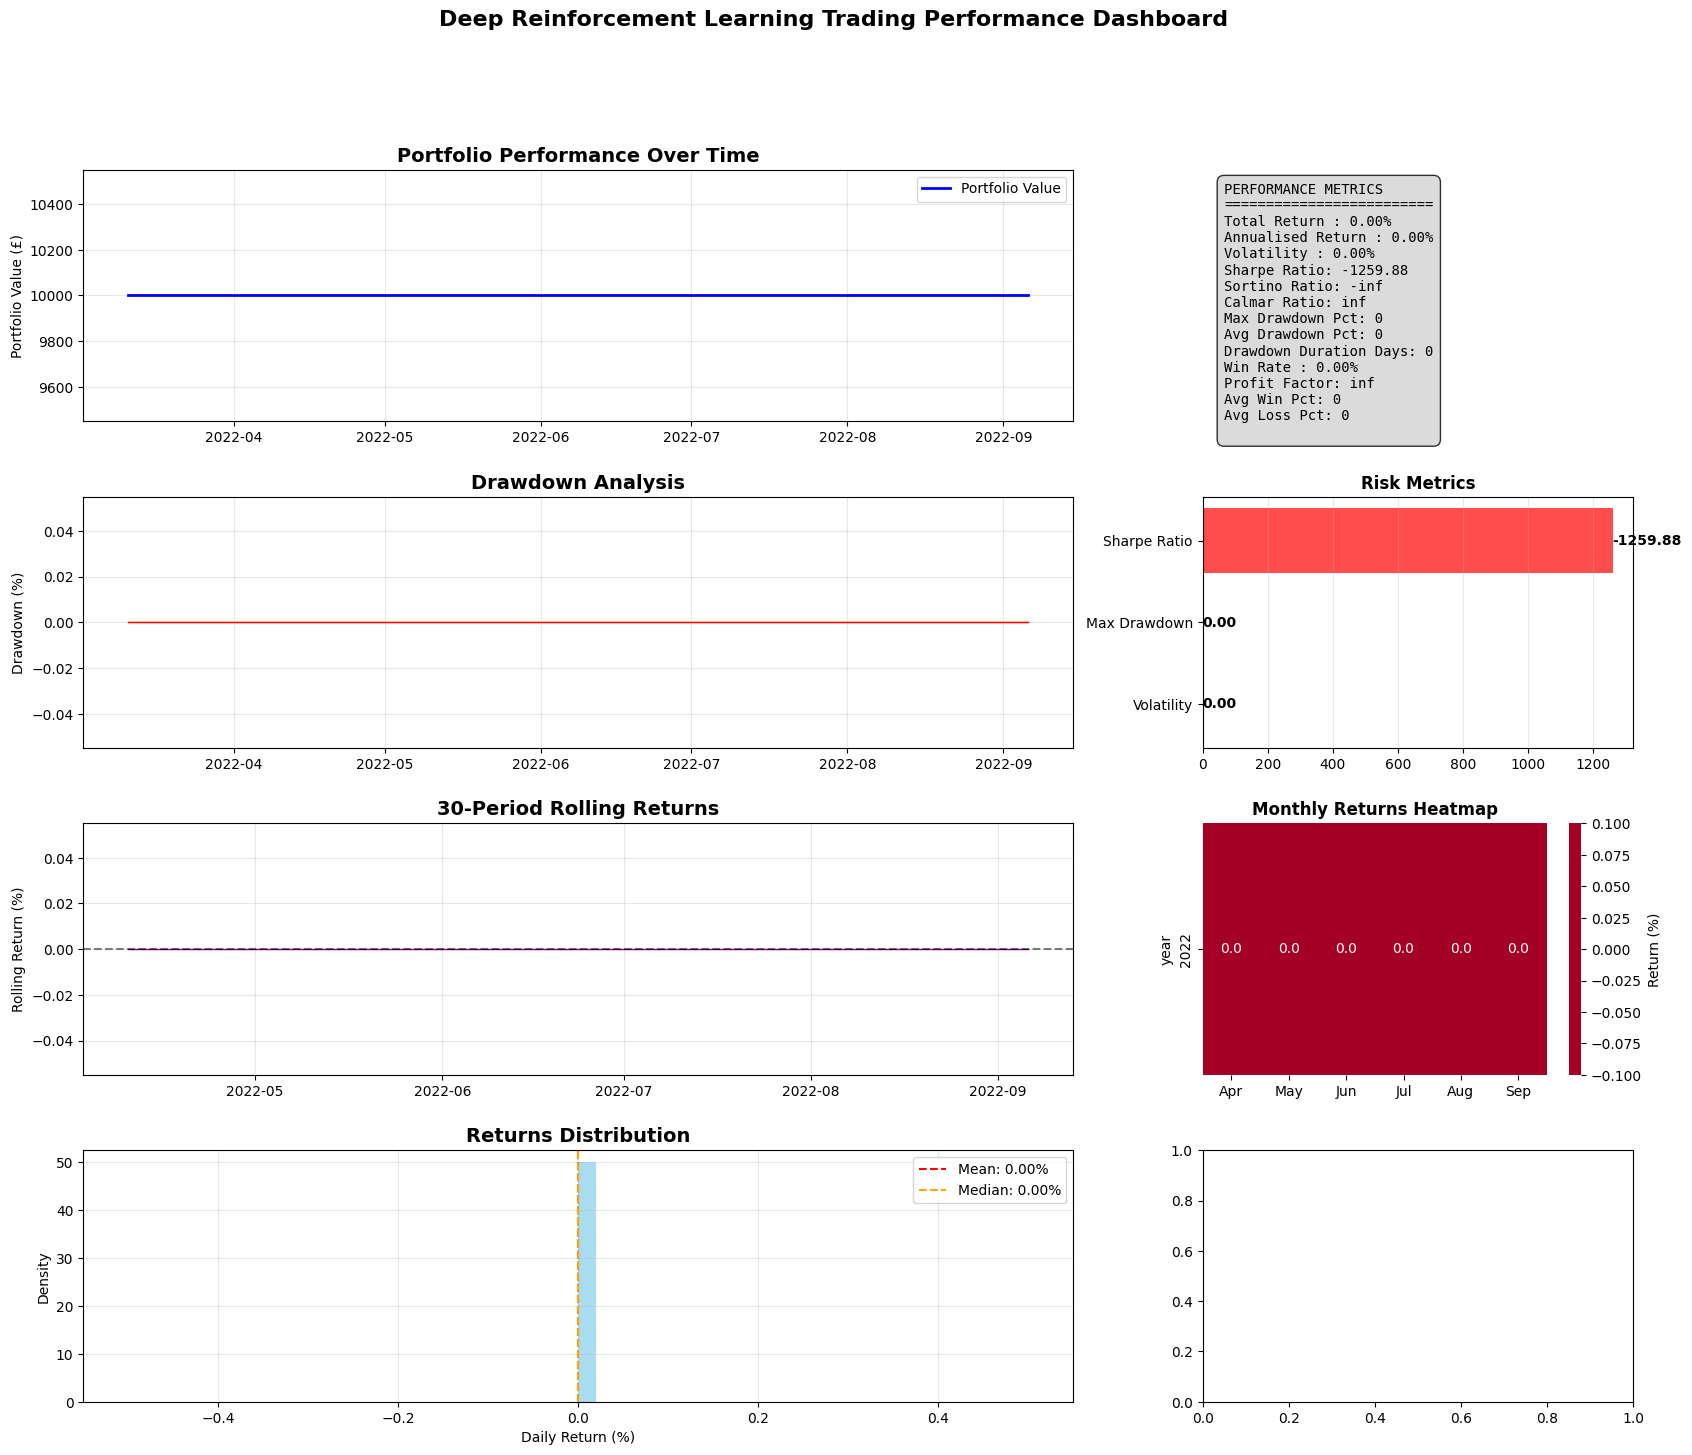


Performance Analysis Complete
Dashboard generated with detailed metrics and visualizations


In [48]:
class PerformanceAnalyser:
    """Performance analysis for trading strategies"""
    
    def __init__(self):
        self.metrics = {}
        
    def calculate_metrics(self, portfolio_values: List[float],
                                      benchmark_returns: List[float] = None,
                                      risk_free_rate: float = 0.02) -> dict:
        """Calculate performance metrics"""
        
        if len(portfolio_values) < 2:
            return {}
        
        # Convert to numpy arrays
        values = np.array(portfolio_values)
        returns = np.diff(values) / values[:-1]
        
        # Basic metrics
        total_return = (values[-1] - values[0]) / values[0]
        annualised_return = (1 + total_return) ** (252 / len(returns)) - 1
        volatility = np.std(returns) * np.sqrt(252)
        
        # Risk-adjusted metrics
        excess_returns = returns - (risk_free_rate / 252)
        sharpe_ratio = np.mean(excess_returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
        
        # Drawdown analysis
        drawdown_info = self._calculate_drawdown_metrics(values)
        
        # Win/Loss analysis
        win_rate = np.sum(returns > 0) / len(returns) if len(returns) > 0 else 0
        avg_win = np.mean(returns[returns > 0]) if np.any(returns > 0) else 0
        avg_loss = np.mean(returns[returns < 0]) if np.any(returns < 0) else 0
        profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
        
        # Advanced metrics
        sortino_ratio = self._calculate_sortino_ratio(returns, risk_free_rate)
        calmar_ratio = annualised_return / (drawdown_info['max_drawdown'] / 100) if drawdown_info['max_drawdown'] > 0 else np.inf
        
        metrics = {
            'total_return_pct': total_return * 100,
            'annualised_return_pct': annualised_return * 100,
            'volatility_pct': volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown_pct': drawdown_info['max_drawdown'],
            'avg_drawdown_pct': drawdown_info['avg_drawdown'],
            'drawdown_duration_days': drawdown_info['max_duration'],
            'win_rate_pct': win_rate * 100,
            'profit_factor': profit_factor,
            'avg_win_pct': avg_win * 100,
            'avg_loss_pct': avg_loss * 100,
        }
        
        # Benchmark comparison if provided
        if benchmark_returns is not None:
            beta, alpha = self._calculate_alpha_beta(returns, benchmark_returns)
            metrics['beta'] = beta
            metrics['alpha_pct'] = alpha * 100
            metrics['information_ratio'] = self._calculate_information_ratio(returns, benchmark_returns)
        
        return metrics
    
    def _calculate_drawdown_metrics(self, values: np.array) -> dict:
        """Calculate detailed drawdown metrics"""
        peak = values[0]
        drawdowns = []
        current_drawdown = 0
        drawdown_start = 0
        
        for i, value in enumerate(values):
            if value > peak:
                if current_drawdown > 0:
                    drawdowns.append({
                        'drawdown': current_drawdown,
                        'duration': i - drawdown_start
                    })
                peak = value
                current_drawdown = 0
            else:
                if current_drawdown == 0:
                    drawdown_start = i
                current_drawdown = (peak - value) / peak * 100
        
        # Add final drawdown if still in one
        if current_drawdown > 0:
            drawdowns.append({
                'drawdown': current_drawdown,
                'duration': len(values) - drawdown_start
            })
        
        if not drawdowns:
            return {'max_drawdown': 0, 'avg_drawdown': 0, 'max_duration': 0}
        
        max_drawdown = max(dd['drawdown'] for dd in drawdowns)
        avg_drawdown = np.mean([dd['drawdown'] for dd in drawdowns])
        max_duration = max(dd['duration'] for dd in drawdowns)
        
        return {
            'max_drawdown': max_drawdown,
            'avg_drawdown': avg_drawdown,
            'max_duration': max_duration
        }
    
    def _calculate_sortino_ratio(self, returns: np.array, risk_free_rate: float) -> float:
        """Calculate Sortino ratio (downside deviation)"""
        excess_returns = returns - (risk_free_rate / 252)
        downside_returns = excess_returns[excess_returns < 0]
        
        if len(downside_returns) == 0:
            return np.inf
        
        downside_deviation = np.std(downside_returns) * np.sqrt(252)
        return np.mean(excess_returns) * np.sqrt(252) / downside_deviation
    
    def _calculate_alpha_beta(self, returns: np.array, benchmark_returns: np.array) -> Tuple[float, float]:
        """Calculate alpha and beta vs benchmark"""
        if len(returns) != len(benchmark_returns):
            return 0, 0
        
        # Beta calculation
        covariance = np.cov(returns, benchmark_returns)[0, 1]
        benchmark_variance = np.var(benchmark_returns)
        beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
        
        # Alpha calculation
        alpha = np.mean(returns) - beta * np.mean(benchmark_returns)
        
        return beta, alpha * 252  # Annualised alpha
    
    def _calculate_information_ratio(self, returns: np.array, benchmark_returns: np.array) -> float:
        """Calculate information ratio"""
        if len(returns) != len(benchmark_returns):
            return 0
        
        excess_returns = returns - benchmark_returns
        return np.mean(excess_returns) / (np.std(excess_returns) + 1e-6) * np.sqrt(252)
    
    def create_performance_dashboard(self, portfolio_values: List[float], 
                                   dates: pd.Series, trades: List[dict] = None,
                                   benchmark_values: List[float] = None):
        """Create performance dashboard"""
        
        # Calculate metrics
        metrics = self.calculate_metrics(portfolio_values)
        
        # Create subplots
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        
        # 1. Portfolio value over time
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(dates, portfolio_values, label='Portfolio Value', linewidth=2, color='blue')
        
        if benchmark_values:
            ax1.plot(dates, benchmark_values, label='Benchmark', linewidth=1, color='orange', alpha=0.7)
        
        # Mark trades
        if trades:
            for trade in trades:
                if 'timestamp' in trade and trade['timestamp'] in dates.values:
                    idx = dates[dates == trade['timestamp']].index[0]
                    if idx < len(portfolio_values):
                        color = 'green' if trade['action'] == 'BUY' else 'red'
                        marker = '^' if trade['action'] == 'BUY' else 'v'
                        ax1.scatter(dates.iloc[idx], portfolio_values[idx], 
                                  color=color, marker=marker, s=50, alpha=0.8)
        
        ax1.set_title('Portfolio Performance Over Time', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Portfolio Value (£)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Drawdown chart
        ax2 = fig.add_subplot(gs[1, :2])
        values = np.array(portfolio_values)
        peak = np.maximum.accumulate(values)
        drawdown = (values - peak) / peak * 100
        
        ax2.fill_between(dates, drawdown, 0, alpha=0.3, color='red')
        ax2.plot(dates, drawdown, color='red', linewidth=1)
        ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)
        
        # 3. Rolling returns
        ax3 = fig.add_subplot(gs[2, :2])
        if len(portfolio_values) > 30:
            returns = np.diff(values) / values[:-1]
            rolling_returns = pd.Series(returns).rolling(window=30).mean() * 100
            ax3.plot(dates[1:], rolling_returns, color='purple', linewidth=1)
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax3.set_title('30-Period Rolling Returns', fontsize=14, fontweight='bold')
            ax3.set_ylabel('Rolling Return (%)')
            ax3.grid(True, alpha=0.3)
        
        # 4. Returns distribution
        ax4 = fig.add_subplot(gs[3, :2])
        if len(portfolio_values) > 1:
            returns = np.diff(values) / values[:-1] * 100
            ax4.hist(returns, bins=50, alpha=0.7, color='skyblue', density=True)
            ax4.axvline(x=np.mean(returns), color='red', linestyle='--', label=f'Mean: {np.mean(returns):.2f}%')
            ax4.axvline(x=np.median(returns), color='orange', linestyle='--', label=f'Median: {np.median(returns):.2f}%')
            ax4.set_title('Returns Distribution', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Daily Return (%)')
            ax4.set_ylabel('Density')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
       
            # 5. Performance metrics table
            ax5 = fig.add_subplot(gs[0, 2])
            ax5.axis('off')
       
        metrics_text = "PERFORMANCE METRICS\n" + "="*25 + "\n"
        for key, value in metrics.items():
            if isinstance(value, float):
                if 'pct' in key or 'rate' in key:
                    metrics_text += f"{key.replace('_', ' ').replace('pct', '').title()}: {value:.2f}%\n"
                else:
                    metrics_text += f"{key.replace('_', ' ').title()}: {value:.2f}\n"
            else:
                metrics_text += f"{key.replace('_', ' ').title()}: {value}\n"
        
        ax5.text(0.05, 0.95, metrics_text, transform=ax5.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
       
        # 6. Risk metrics visualization
        ax6 = fig.add_subplot(gs[1, 2])
        risk_metrics = ['Volatility', 'Max Drawdown', 'Sharpe Ratio', 'Sortino Ratio']
        risk_values = [metrics.get('volatility_pct', 0), metrics.get('max_drawdown_pct', 0),
                        metrics.get('sharpe_ratio', 0), metrics.get('sortino_ratio', 0)]
        
        colors = ['red' if v < 0 else 'green' for v in risk_values]
        bars = ax6.barh(risk_metrics, [abs(v) for v in risk_values], color=colors, alpha=0.7)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, risk_values)):
            width = bar.get_width()
            ax6.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{val:.2f}', ha='left', va='center', fontweight='bold')
        
        ax6.set_title('Risk Metrics', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='x')
       
        # 7. Monthly returns heatmap
        ax7 = fig.add_subplot(gs[2, 2])
        if len(portfolio_values) > 30:
            monthly_returns = self._calculate_monthly_returns(portfolio_values, dates)
            if len(monthly_returns) > 0:
                sns.heatmap(monthly_returns, annot=True, fmt='.1f', cmap='RdYlGn', 
                            center=0, ax=ax7, cbar_kws={'label': 'Return (%)'})
                ax7.set_title('Monthly Returns Heatmap', fontsize=12, fontweight='bold')
       
        # 8. Trade analysis
        ax8 = fig.add_subplot(gs[3, 2])
        if trades:
            trade_returns = []
            for i, trade in enumerate(trades[::2]):  # Every other trade (buy-sell pairs)
                if i+1 < len(trades):
                    buy_price = trade.get('price', 0)
                    sell_trade = trades[i*2+1] if i*2+1 < len(trades) else None
                    if sell_trade:
                        sell_price = sell_trade.get('price', buy_price)
                        ret = (sell_price - buy_price) / buy_price * 100
                        trade_returns.append(ret)
            
            if trade_returns:
                wins = [r for r in trade_returns if r > 0]
                losses = [r for r in trade_returns if r <= 0]
                
                ax8.bar(['Winning Trades', 'Losing Trades'], 
                        [len(wins), len(losses)], 
                        color=['green', 'red'], alpha=0.7)
                ax8.set_title('Trade Outcome Distribution', fontsize=12, fontweight='bold')
                ax8.set_ylabel('Number of Trades')
        
        plt.suptitle('Deep Reinforcement Learning Trading Performance Dashboard', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        return metrics
   
    def _calculate_monthly_returns(self, portfolio_values: List[float], 
                                    dates: pd.Series) -> pd.DataFrame:
        """Calculate monthly returns for heatmap"""
        try:
            df = pd.DataFrame({'date': dates, 'value': portfolio_values})
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            
            # Resample to monthly
            monthly = df.resample('M').last()
            monthly_returns = monthly.pct_change().dropna() * 100
            
            # Create year-month matrix
            monthly_returns.index = pd.to_datetime(monthly_returns.index)
            monthly_returns['year'] = monthly_returns.index.year
            monthly_returns['month'] = monthly_returns.index.month
            
            pivot_table = monthly_returns.pivot_table(
                values='value', 
                index='year', 
                columns='month', 
                fill_value=0
            )
            
            # Rename columns to month names
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            pivot_table.columns = [month_names[i-1] for i in pivot_table.columns]
            
            return pivot_table
        except:
            return pd.DataFrame()

def create_strategy_comparison_report(strategies: dict, test_data: pd.DataFrame):
   """Create strategy comparison report"""
   
   analyser = PerformanceAnalyser()
   comparison_data = []
   
   print("STRATEGY COMPARISON REPORT")
   print("=" * 60)
   
   for strategy_name, results in strategies.items():
       metrics = analyser.calculate_metrics(results['portfolio_values'])
       metrics['strategy'] = strategy_name
       comparison_data.append(metrics)
       
       print(f"\n{strategy_name.upper()}")
       print("-" * 30)
       print(f"Total Return: {metrics.get('total_return_pct', 0):.2f}%")
       print(f"Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
       print(f"Max Drawdown: {metrics.get('max_drawdown_pct', 0):.2f}%")
       print(f"Win Rate: {metrics.get('win_rate_pct', 0):.2f}%")
   
   # Create comparison DataFrame
   df_comparison = pd.DataFrame(comparison_data)
   df_comparison.set_index('strategy', inplace=True)
   
   # Plot comparison charts
   fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
   
   # Returns comparison
   strategies_list = list(strategies.keys())
   returns = [df_comparison.loc[s, 'total_return_pct'] for s in strategies_list]
   colors = plt.cm.Set3(np.linspace(0, 1, len(strategies_list)))
   
   bars1 = ax1.bar(strategies_list, returns, color=colors, alpha=0.8)
   ax1.set_title('Total Returns Comparison')
   ax1.set_ylabel('Total Return (%)')
   ax1.grid(True, alpha=0.3, axis='y')
   
   # Add value labels
   for bar, ret in zip(bars1, returns):
       height = bar.get_height()
       ax1.text(bar.get_x() + bar.get_width()/2., height,
               f'{ret:.1f}%', ha='center', va='bottom', fontweight='bold')
   
   # Sharpe ratio comparison
   sharpe_ratios = [df_comparison.loc[s, 'sharpe_ratio'] for s in strategies_list]
   bars2 = ax2.bar(strategies_list, sharpe_ratios, color=colors, alpha=0.8)
   ax2.set_title('Sharpe Ratio Comparison')
   ax2.set_ylabel('Sharpe Ratio')
   ax2.grid(True, alpha=0.3, axis='y')
   
   for bar, sharpe in zip(bars2, sharpe_ratios):
       height = bar.get_height()
       ax2.text(bar.get_x() + bar.get_width()/2., height,
               f'{sharpe:.2f}', ha='center', va='bottom', fontweight='bold')
   
   # Max drawdown comparison
   drawdowns = [df_comparison.loc[s, 'max_drawdown_pct'] for s in strategies_list]
   bars3 = ax3.bar(strategies_list, drawdowns, color='red', alpha=0.6)
   ax3.set_title('Maximum Drawdown Comparison')
   ax3.set_ylabel('Max Drawdown (%)')
   ax3.grid(True, alpha=0.3, axis='y')
   
   for bar, dd in zip(bars3, drawdowns):
       height = bar.get_height()
       ax3.text(bar.get_x() + bar.get_width()/2., height,
               f'{dd:.1f}%', ha='center', va='bottom', fontweight='bold')
   
   # Portfolio value evolution
   for strategy_name, results in strategies.items():
       dates = test_data['date'][:len(results['portfolio_values'])]
       ax4.plot(dates, results['portfolio_values'], label=strategy_name, linewidth=2)
   
   ax4.set_title('Portfolio Value Evolution')
   ax4.set_xlabel('Date')
   ax4.set_ylabel('Portfolio Value (£)')
   ax4.legend()
   ax4.grid(True, alpha=0.3)
   ax4.tick_params(axis='x', rotation=45)
   
   plt.tight_layout()
   plt.show()
   
   return df_comparison

# Create performance analyser instance
performance_analyser = PerformanceAnalyser()

# Example: Create dashboard for our trained agent
print("Creating performance dashboard for trained DQN agent...")

# Use the backtest results from previous cell
if 'backtest_results' in locals():
   dates = test_data['date'][:len(backtest_results['net_worths'])]
   
   # Create dashboard
   detailed_metrics = performance_analyser.create_performance_dashboard(
       portfolio_values=backtest_results['net_worths'],
       dates=dates,
       trades=backtest_results['trades']
   )
   
   print("\nPerformance Analysis Complete")
   print("Dashboard generated with detailed metrics and visualizations")
else:
   print("Run the backtest first to generate performance dashboard")

### Model Persistence and Deployment

In [51]:
import pickle
import json
from datetime import datetime
import os
from typing import Dict, Any

class ModelManager:
    """Manage model saving, loading, and versioning"""
    
    def __init__(self, models_dir: str = "models"):
        self.models_dir = models_dir
        os.makedirs(models_dir, exist_ok=True)
    
    def save_complete_model(self, agent: DQNAgent, training_info: Dict[str, Any],
                           model_name: str = None) -> str:
        """Save complete model with metadata"""
        
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"dqn_trading_model_{timestamp}"
        
        model_path = os.path.join(self.models_dir, model_name)
        os.makedirs(model_path, exist_ok=True)
        
        # Save PyTorch model
        model_file = os.path.join(model_path, "model.pth")
        agent.save_model(model_file)
        
        # Save training configuration and metadata
        metadata = {
            'model_name': model_name,
            'creation_date': datetime.now().isoformat(),
            'model_type': 'DQN',
            'state_size': agent.state_size,
            'action_size': agent.action_size,
            'training_info': training_info,
            'hyperparameters': {
                'gamma': agent.gamma,
                'epsilon': agent.epsilon,
                'epsilon_decay': agent.epsilon_decay,
                'epsilon_min': agent.epsilon_min,
                'learning_rate': agent.optimizer.param_groups[0]['lr'],
                'memory_size': agent.memory.buffer.maxlen
            }
        }
        
        metadata_file = os.path.join(model_path, "metadata.json")
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save training history if available
        if 'training_history' in training_info:
            history_file = os.path.join(model_path, "training_history.pkl")
            with open(history_file, 'wb') as f:
                pickle.dump(training_info['training_history'], f)
        
        print(f"Model saved successfully to: {model_path}")
        return model_path
    
    def load_complete_model(self, model_path: str) -> tuple:
        """Load complete model with metadata"""
        
        # Load metadata
        metadata_file = os.path.join(model_path, "metadata.json")
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        # Recreate agent
        agent = DQNAgent(
            state_size=metadata['state_size'],
            action_size=metadata['action_size'],
            lr=metadata['hyperparameters']['learning_rate'],
            gamma=metadata['hyperparameters']['gamma'],
            epsilon=metadata['hyperparameters']['epsilon_min'],  # Start with min epsilon for inference
            epsilon_decay=metadata['hyperparameters']['epsilon_decay'],
            epsilon_min=metadata['hyperparameters']['epsilon_min'],
            memory_size=metadata['hyperparameters']['memory_size']
        )
        
        # Load model weights
        model_file = os.path.join(model_path, "model.pth")
        agent.load_model(model_file)
        
        # Load training history if available
        training_history = None
        history_file = os.path.join(model_path, "training_history.pkl")
        if os.path.exists(history_file):
            with open(history_file, 'rb') as f:
                training_history = pickle.load(f)
        
        print(f"Model loaded successfully from: {model_path}")
        print(f"Model: {metadata['model_name']}")
        print(f"Created: {metadata['creation_date']}")
        
        return agent, metadata, training_history
    
    def list_models(self) -> List[Dict[str, Any]]:
        """List all saved models"""
        models = []
        
        if not os.path.exists(self.models_dir):
            return models
        
        for item in os.listdir(self.models_dir):
            model_path = os.path.join(self.models_dir, item)
            metadata_file = os.path.join(model_path, "metadata.json")
            
            if os.path.isdir(model_path) and os.path.exists(metadata_file):
                try:
                    with open(metadata_file, 'r') as f:
                        metadata = json.load(f)
                    models.append({
                        'path': model_path,
                        'name': metadata['model_name'],
                        'creation_date': metadata['creation_date'],
                        'model_type': metadata['model_type']
                    })
                except:
                    continue
        
        return sorted(models, key=lambda x: x['creation_date'], reverse=True)

class ProductionTradingSystem:
    """Production-ready trading system"""
    
    def __init__(self, model_path: str, symbol: str = 'AAPL'):
        self.model_manager = ModelManager()
        self.symbol = symbol
        
        # Load model
        self.agent, self.metadata, self.training_history = self.model_manager.load_complete_model(model_path)
        
        # Initialize components
        self.ib_conn = IBConnection()
        self.risk_manager = RiskManager()
        
        # Trading state
        self.is_running = False
        self.price_history = deque(maxlen=50)
        self.position_history = []
        self.performance_metrics = {}
        
        print(f"Production trading system initialized for {symbol}")
        print(f"Using model: {self.metadata['model_name']}")
    
    def start_paper_trading(self, duration_hours: int = 8, check_interval: int = 60):
        """Start paper trading session"""
        
        if not self.ib_conn.connect():
            print("Failed to connect to Interactive Brokers")
            return False
        
        print(f"Starting paper trading session for {duration_hours} hours")
        print(f"Check interval: {check_interval} seconds")
        
        self.is_running = True
        session_start = datetime.now()
        session_end = session_start + timedelta(hours=duration_hours)
        
        session_log = {
            'start_time': session_start,
            'end_time': session_end,
            'trades': [],
            'portfolio_values': [],
            'signals': []
        }
        
        try:
            while self.is_running and datetime.now() < session_end:
                # Get market data
                market_data = self.ib_conn.get_market_data(self.symbol)
                
                if market_data:
                    current_price = market_data['last']
                    timestamp = datetime.now()
                    
                    # Update price history
                    self.price_history.append(current_price)
                    
                    # Generate trading signal if enough data
                    if len(self.price_history) >= 20:
                        state = self._prepare_state()
                        action = self.agent.act(state, training=False)
                        
                        signal_info = {
                            'timestamp': timestamp,
                            'price': current_price,
                            'action': ['HOLD', 'BUY', 'SELL'][action],
                            'confidence': self._get_action_confidence(state)
                        }
                        
                        session_log['signals'].append(signal_info)
                        
                        print(f"{timestamp.strftime('%H:%M:%S')} | "
                              f"Price: £{current_price:.2f} | "
                              f"Signal: {signal_info['action']} | "
                              f"Confidence: {signal_info['confidence']:.2f}")
                        
                        # Execute trade logic (implement according to your strategy)
                        if action != 0 and signal_info['confidence'] > 0.7:
                            trade_executed = self._execute_production_trade(action, current_price)
                            if trade_executed:
                                session_log['trades'].append(trade_executed)
                
                time.sleep(check_interval)
                
        except KeyboardInterrupt:
            print("Trading session interrupted by user")
        finally:
            self.is_running = False
            self.ib_conn.disconnect()
            
            # Save session log
            self._save_session_log(session_log)
            print("Paper trading session completed")
            
        return session_log
    
    def _prepare_state(self) -> np.array:
        """Prepare state for model inference"""
        if len(self.price_history) < 20:
            return None
        
        # Calculate returns
        prices = list(self.price_history)
        returns = [prices[i] / prices[i-1] - 1 for i in range(1, len(prices))]
        
        # Take last 20 returns
        returns = returns[-20:] if len(returns) >= 20 else [0] * (20 - len(returns)) + returns
        
        # Add position information (simplified for demo)
        state = returns + [0.0, 0.0, 1.0]  # No position, full cash
        
        return np.array(state, dtype=np.float32)
    
    def _get_action_confidence(self, state: np.array) -> float:
        """Get confidence score for the action"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.agent.q_network(state_tensor)
        
        # Use max Q-value as confidence measure
        max_q = torch.max(q_values).item()
        min_q = torch.min(q_values).item()
        
        # Normalise to 0-1 scale
        if max_q != min_q:
            confidence = (max_q - min_q) / max(abs(max_q), abs(min_q))
        else:
            confidence = 0.5
        
        return max(0.0, min(1.0, confidence))
    
    def _execute_production_trade(self, action: int, price: float) -> Dict[str, Any]:
        """Execute trade in production environment"""
        # This is where you would implement actual trade execution logic
        # For demo purposes, we'll simulate the trade
        
        trade_info = {
            'timestamp': datetime.now(),
            'symbol': self.symbol,
            'action': ['HOLD', 'BUY', 'SELL'][action],
            'price': price,
            'quantity': 100,  # Demo quantity
            'status': 'SIMULATED'
        }
        
        print(f"Trade executed: {trade_info}")
        return trade_info
    
    def _save_session_log(self, session_log: Dict[str, Any]):
        """Save trading session log"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = f"trading_session_{timestamp}.json"
        
        # Convert datetime objects to strings for JSON serialization
        session_log_serializable = {
            'start_time': session_log['start_time'].isoformat(),
            'end_time': session_log['end_time'].isoformat(),
            'trades': session_log['trades'],
            'signals': session_log['signals'],
            'portfolio_values': session_log['portfolio_values']
        }
        
        with open(log_file, 'w') as f:
            json.dump(session_log_serializable, f, indent=2, default=str)
        
        print(f"Session log saved to: {log_file}")

# Example usage and model management
model_manager = ModelManager()

# Save the trained model with complete information
if 'trained_agent' in locals():
    training_info = {
        'episodes': 300,
        'final_epsilon': trained_agent.epsilon,
        'training_data_size': len(train_data),
        'test_performance': backtest_results['metrics'] if 'backtest_results' in locals() else {},
        'training_date': datetime.now().isoformat()
    }
    
    saved_model_path = model_manager.save_complete_model(
        agent=trained_agent,
        training_info=training_info,
        model_name="dqn_trading_v1"
    )
    
    print(f"Model saved to: {saved_model_path}")

# List available models
print("\nAvailable Models:")
print("=" * 40)
models = model_manager.list_models()
for model in models:
    print(f"Name: {model['name']}")
    print(f"Created: {model['creation_date']}")
    print(f"Path: {model['path']}")
    print("-" * 40)

print("\nProduction trading system ready!")
print("To start paper trading, use:")
print("production_system = ProductionTradingSystem('models/dqn_trading_v1')")
print("production_system.start_paper_trading(duration_hours=1)")

Model saved to models/dqn_trading_v1/model.pth
Model saved successfully to: models/dqn_trading_v1
Model saved to: models/dqn_trading_v1

Available Models:
Name: dqn_trading_v1
Created: 2025-08-28T11:00:49.279015
Path: models/dqn_trading_v1
----------------------------------------

Production trading system ready!
To start paper trading, use:
production_system = ProductionTradingSystem('models/dqn_trading_v1')
production_system.start_paper_trading(duration_hours=1)


### Advanced Strategy Research and Experimentation

In [53]:
class AdvancedTradingResearch:
    """Advanced research tools for trading strategy development"""
    
    def __init__(self):
        self.research_results = {}
    
    def multi_timeframe_analysis(self, data: pd.DataFrame, timeframes: List[str] = None):
        """Analyse trading opportunities across multiple timeframes"""
        
        if timeframes is None:
            timeframes = ['1H', '4H', '1D']  # 1 hour, 4 hours, 1 day
        
        print("MULTI-TIMEFRAME ANALYSIS")
        print("=" * 50)
        
        analysis_results = {}
        
        # Resample data to different timeframes
        data_copy = data.copy()
        data_copy['date'] = pd.to_datetime(data_copy['date'])
        data_copy.set_index('date', inplace=True)
        
        for timeframe in timeframes:
            try:
                # Resample to timeframe
                resampled = data_copy.resample(timeframe).agg({
                    'open': 'first',
                    'high': 'max',
                    'low': 'min',
                    'close': 'last',
                    'volume': 'sum'
                }).dropna()
                
                if len(resampled) < 50:  # Need minimum data
                    continue
                
                # Calculate technical indicators
                indicators = self._calculate_technical_indicators(resampled)
                
                # Analyse trend and momentum
                trend_analysis = self._analyse_trend_momentum(resampled, indicators)
                
                analysis_results[timeframe] = {
                    'data_points': len(resampled),
                    'price_change': (resampled['close'].iloc[-1] - resampled['close'].iloc[0]) / resampled['close'].iloc[0] * 100,
                    'volatility': resampled['close'].pct_change().std() * 100,
                    'trend': trend_analysis['trend'],
                    'momentum': trend_analysis['momentum'],
                    'support_level': resampled['low'].rolling(20).min().iloc[-1],
                    'resistance_level': resampled['high'].rolling(20).max().iloc[-1]
                }
                
                print(f"\n{timeframe} Timeframe:")
                print(f"  Data points: {analysis_results[timeframe]['data_points']}")
                print(f"  Price change: {analysis_results[timeframe]['price_change']:.2f}%")
                print(f"  Volatility: {analysis_results[timeframe]['volatility']:.2f}%")
                print(f"  Trend: {analysis_results[timeframe]['trend']}")
                print(f"  Momentum: {analysis_results[timeframe]['momentum']}")
                
            except Exception as e:
                print(f"Error analysing {timeframe}: {e}")
                continue
        
        return analysis_results
    
    def _calculate_technical_indicators(self, data: pd.DataFrame) -> dict:
        """Calculate technical indicators"""
        indicators = {}
        
        # Moving averages
        indicators['sma_20'] = data['close'].rolling(20).mean()
        indicators['sma_50'] = data['close'].rolling(50).mean()
        indicators['ema_12'] = data['close'].ewm(span=12).mean()
        indicators['ema_26'] = data['close'].ewm(span=26).mean()
        
        # MACD
        indicators['macd'] = indicators['ema_12'] - indicators['ema_26']
        indicators['macd_signal'] = indicators['macd'].ewm(span=9).mean()
        
        # RSI
        delta = data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        indicators['rsi'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        indicators['bb_middle'] = data['close'].rolling(20).mean()
        bb_std = data['close'].rolling(20).std()
        indicators['bb_upper'] = indicators['bb_middle'] + (bb_std * 2)
        indicators['bb_lower'] = indicators['bb_middle'] - (bb_std * 2)
        
        return indicators
    
    def _analyse_trend_momentum(self, data: pd.DataFrame, indicators: dict) -> dict:
        """Analyse trend and momentum"""
        
        # Trend analysis
        sma_20 = indicators['sma_20'].iloc[-1]
        sma_50 = indicators['sma_50'].iloc[-1]
        current_price = data['close'].iloc[-1]
        
        if current_price > sma_20 > sma_50:
            trend = "STRONG_UPTREND"
        elif current_price > sma_20 and sma_20 < sma_50:
            trend = "WEAK_UPTREND"
        elif current_price < sma_20 < sma_50:
            trend = "STRONG_DOWNTREND"
        elif current_price < sma_20 and sma_20 > sma_50:
            trend = "WEAK_DOWNTREND"
        else:
            trend = "SIDEWAYS"
        
        # Momentum analysis
        rsi = indicators['rsi'].iloc[-1]
        macd = indicators['macd'].iloc[-1]
        macd_signal = indicators['macd_signal'].iloc[-1]
        
        if rsi > 70 and macd > macd_signal:
            momentum = "OVERBOUGHT_BULLISH"
        elif rsi > 70 and macd < macd_signal:
            momentum = "OVERBOUGHT_BEARISH"
        elif rsi < 30 and macd < macd_signal:
            momentum = "OVERSOLD_BEARISH"
        elif rsi < 30 and macd > macd_signal:
            momentum = "OVERSOLD_BULLISH"
        elif macd > macd_signal:
            momentum = "BULLISH"
        elif macd < macd_signal:
            momentum = "BEARISH"
        else:
            momentum = "NEUTRAL"
        
        return {'trend': trend, 'momentum': momentum}
    
    def parameter_sensitivity_analysis(self, base_agent: DQNAgent, 
                                     train_data: pd.DataFrame,
                                     test_data: pd.DataFrame):
        """Analyse sensitivity to hyperparameters"""
        
        print("PARAMETER SENSITIVITY ANALYSIS")
        print("=" * 50)
        
        # Define parameter ranges to test
        parameter_ranges = {
            'learning_rate': [0.0001, 0.001, 0.01],
            'gamma': [0.9, 0.95, 0.99],
            'epsilon_decay': [0.99, 0.995, 0.999],
            'memory_size': [5000, 10000, 20000]
        }
       
        sensitivity_results = {}
        base_performance = None
       
        for param_name, param_values in parameter_ranges.items():
            print(f"\nTesting {param_name}...")
            param_results = {}
            
            for param_value in param_values:
                print(f"  Testing {param_name} = {param_value}")
                
                # Create agent with modified parameter
                test_agent = self._create_modified_agent(base_agent, param_name, param_value)
                
                # Quick training (fewer episodes for sensitivity analysis)
                trained_agent = self._quick_train_agent(test_agent, train_data, episodes=100)
                
                # Test performance
                test_results = self._quick_backtest(trained_agent, test_data)
                
                param_results[param_value] = {
                    'total_return': test_results['metrics']['total_return'],
                    'sharpe_ratio': test_results['metrics']['sharpe_ratio'],
                    'max_drawdown': test_results['metrics']['max_drawdown']
                }
                
                print(f"    Return: {test_results['metrics']['total_return']:.2f}%")
                print(f"    Sharpe: {test_results['metrics']['sharpe_ratio']:.2f}")
            
            sensitivity_results[param_name] = param_results
        
        # Visualise sensitivity analysis
        self._plot_sensitivity_analysis(sensitivity_results)
        
        return sensitivity_results
   
    def _create_modified_agent(self, base_agent: DQNAgent, param_name: str, param_value):
        """Create agent with modified parameter"""
        
        # Get base parameters
        base_params = {
            'state_size': base_agent.state_size,
            'action_size': base_agent.action_size,
            'lr': base_agent.optimizer.param_groups[0]['lr'],
            'gamma': base_agent.gamma,
            'epsilon_decay': base_agent.epsilon_decay,
            'memory_size': base_agent.memory.buffer.maxlen
        }
        
        # Modify specific parameter
        if param_name == 'learning_rate':
            base_params['lr'] = param_value
        elif param_name == 'gamma':
            base_params['gamma'] = param_value
        elif param_name == 'epsilon_decay':
            base_params['epsilon_decay'] = param_value
        elif param_name == 'memory_size':
            base_params['memory_size'] = param_value
        
        # Create new agent
        return DQNAgent(
            state_size=base_params['state_size'],
            action_size=base_params['action_size'],
            lr=base_params['lr'],
            gamma=base_params['gamma'],
            epsilon_decay=base_params['epsilon_decay'],
            memory_size=base_params['memory_size']
        )
   
    def _quick_train_agent(self, agent: DQNAgent, train_data: pd.DataFrame, episodes: int = 100):
        """Quick training for sensitivity analysis"""
        
        env = TradingEnvironment(train_data, initial_balance=10000)
        
        for episode in range(episodes):
            state = env.reset()
            done = False
            
            while not done:
                action = agent.act(state, training=True)
                next_state, reward, done, info = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                
                if len(agent.memory) > 32:
                    agent.replay(batch_size=32)
        
        return agent
   
    def _quick_backtest(self, agent: DQNAgent, test_data: pd.DataFrame):
        """Quick backtest for sensitivity analysis"""
        
        test_env = TradingEnvironment(test_data, initial_balance=10000)
        
        state = test_env.reset()
        done = False
        
        while not done:
            action = agent.act(state, training=False)
            state, reward, done, info = test_env.step(action)
        
        metrics = test_env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': test_env.net_worths,
            'trades': test_env.trades
        }
   
    def _plot_sensitivity_analysis(self, sensitivity_results: dict):
        """Plot sensitivity analysis results"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for idx, (param_name, param_results) in enumerate(sensitivity_results.items()):
            if idx >= 4:
                break
                
            ax = axes[idx]
            
            param_values = list(param_results.keys())
            returns = [param_results[pv]['total_return'] for pv in param_values]
            sharpe_ratios = [param_results[pv]['sharpe_ratio'] for pv in param_values]
            
            # Plot returns
            ax2 = ax.twinx()
            
            line1 = ax.plot(param_values, returns, 'b-o', label='Total Return (%)', linewidth=2)
            line2 = ax2.plot(param_values, sharpe_ratios, 'r-s', label='Sharpe Ratio', linewidth=2)
            
            ax.set_xlabel(param_name.replace('_', ' ').title())
            ax.set_ylabel('Total Return (%)', color='b')
            ax2.set_ylabel('Sharpe Ratio', color='r')
            
            ax.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')
            
            ax.set_title(f'Sensitivity to {param_name.replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
            
            # Add legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper left')
        
        plt.tight_layout()
        plt.show()
   
    def ensemble_strategy_research(self, train_data: pd.DataFrame, test_data: pd.DataFrame):
        """Research ensemble strategies combining multiple agents"""
        
        print("ENSEMBLE STRATEGY RESEARCH")
        print("=" * 50)
        
        # Train multiple agents with different configurations
        agents = {}
        
        # Agent 1: Conservative (high gamma, low learning rate)
        print("Training Conservative Agent...")
        agents['conservative'] = DQNAgent(
            state_size=23, lr=0.0005, gamma=0.99, epsilon_decay=0.999
        )
        self._quick_train_agent(agents['conservative'], train_data, episodes=200)
        
        # Agent 2: Aggressive (low gamma, high learning rate)
        print("Training Aggressive Agent...")
        agents['aggressive'] = DQNAgent(
            state_size=23, lr=0.005, gamma=0.9, epsilon_decay=0.99
        )
        self._quick_train_agent(agents['aggressive'], train_data, episodes=200)
        
        # Agent 3: Balanced (medium parameters)
        print("Training Balanced Agent...")
        agents['balanced'] = DQNAgent(
            state_size=23, lr=0.001, gamma=0.95, epsilon_decay=0.995
        )
        self._quick_train_agent(agents['balanced'], train_data, episodes=200)
        
        # Test individual agents
        individual_results = {}
        for name, agent in agents.items():
            print(f"Testing {name} agent...")
            results = self._quick_backtest(agent, test_data)
            individual_results[name] = results
        
        # Test ensemble strategies
        ensemble_results = {}
        
        # Majority voting ensemble
        print("Testing Majority Voting Ensemble...")
        ensemble_results['majority_vote'] = self._test_ensemble_majority_vote(
            agents, test_data
        )
        
        # Weighted ensemble
        print("Testing Weighted Ensemble...")
        ensemble_results['weighted'] = self._test_ensemble_weighted(
            agents, individual_results, test_data
        )
        
        # Display results
        all_results = {**individual_results, **ensemble_results}
        self._display_ensemble_comparison(all_results)
        
        return all_results
   
    def _test_ensemble_majority_vote(self, agents: dict, test_data: pd.DataFrame):
        """Test majority voting ensemble"""
        
        env = TradingEnvironment(test_data, initial_balance=10000)
        state = env.reset()
        done = False
        
        while not done:
            # Get votes from all agents
            votes = []
            for agent in agents.values():
                action = agent.act(state, training=False)
                votes.append(action)
            
            # Majority vote
            ensemble_action = max(set(votes), key=votes.count)
            
            state, reward, done, info = env.step(ensemble_action)
        
        metrics = env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': env.net_worths,
            'trades': env.trades
        }
   
    def _test_ensemble_weighted(self, agents: dict, individual_results: dict, test_data: pd.DataFrame):
        """Test weighted ensemble based on individual performance"""
        
        # Calculate weights based on Sharpe ratios
        sharpe_ratios = {name: results['metrics']['sharpe_ratio'] 
                        for name, results in individual_results.items()}
        
        total_sharpe = sum(max(0, sr) for sr in sharpe_ratios.values())
        weights = {name: max(0, sr) / total_sharpe if total_sharpe > 0 else 1/len(agents)
                    for name, sr in sharpe_ratios.items()}
        
        print(f"Ensemble weights: {weights}")
        
        env = TradingEnvironment(test_data, initial_balance=10000)
        state = env.reset()
        done = False
        
        while not done:
            # Get Q-values from all agents
            agent_q_values = {}
            for name, agent in agents.items():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = agent.q_network(state_tensor).detach().numpy()[0]
                agent_q_values[name] = q_values
            
            # Weighted average of Q-values
            weighted_q_values = np.zeros(3)  # 3 actions
            for name, q_values in agent_q_values.items():
                weighted_q_values += weights[name] * q_values
            
            # Select action with highest weighted Q-value
            ensemble_action = np.argmax(weighted_q_values)
            
            state, reward, done, info = env.step(ensemble_action)
        
        metrics = env.get_performance_metrics()
        
        return {
            'metrics': metrics,
            'net_worths': env.net_worths,
            'trades': env.trades
        }
   
    def _display_ensemble_comparison(self, results: dict):
        """Display ensemble comparison results"""
        
        print("\nENSEMBLE COMPARISON RESULTS")
        print("=" * 60)
        
        comparison_df = pd.DataFrame({
            name: {
                'Total Return (%)': result['metrics']['total_return'],
                'Sharpe Ratio': result['metrics']['sharpe_ratio'],
                'Max Drawdown (%)': result['metrics']['max_drawdown'],
                'Win Rate (%)': result['metrics']['win_rate_pct'],
                'Total Trades': result['metrics']['total_trades']
            }
            for name, result in results.items()
        }).T
        
        print(comparison_df.round(2))
        
        # Plot comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        strategies = list(results.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))
        
        # Returns comparison
        returns = [results[s]['metrics']['total_return'] for s in strategies]
        bars1 = ax1.bar(strategies, returns, color=colors, alpha=0.8)
        ax1.set_title('Total Returns Comparison')
        ax1.set_ylabel('Total Return (%)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Sharpe ratio comparison
        sharpes = [results[s]['metrics']['sharpe_ratio'] for s in strategies]
        bars2 = ax2.bar(strategies, sharpes, color=colors, alpha=0.8)
        ax2.set_title('Sharpe Ratio Comparison')
        ax2.set_ylabel('Sharpe Ratio')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Portfolio evolution
        for i, (name, result) in enumerate(results.items()):
            dates = test_data['date'][:len(result['net_worths'])]
            ax3.plot(dates, result['net_worths'], label=name, linewidth=2, color=colors[i])
        
        ax3.set_title('Portfolio Value Evolution')
        ax3.set_ylabel('Portfolio Value (£)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # Risk-Return scatter
        ax4.scatter(
            [results[s]['metrics']['volatility'] for s in strategies],
            returns,
            s=100, alpha=0.7, c=colors
        )
        
        for i, strategy in enumerate(strategies):
            ax4.annotate(strategy, 
                        (results[strategy]['metrics']['volatility'], 
                            results[strategy]['metrics']['total_return']),
                        xytext=(5, 5), textcoords='offset points')
        
        ax4.set_xlabel('Volatility (%)')
        ax4.set_ylabel('Total Return (%)')
        ax4.set_title('Risk-Return Profile')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Initialize advanced research tools
research_tools = AdvancedTradingResearch()

# Example: Multi-timeframe analysis
if 'market_data' in locals():
   print("Running Multi-Timeframe Analysis...")
   timeframe_analysis = research_tools.multi_timeframe_analysis(market_data)

# Example: Parameter sensitivity analysis
if 'trained_agent' in locals() and 'train_data' in locals() and 'test_data' in locals():
   print("\nRunning Parameter Sensitivity Analysis...")
   # Note: This will take some time as it trains multiple models
   # sensitivity_results = research_tools.parameter_sensitivity_analysis(
   #     trained_agent, train_data, test_data
   # )

# Example: Ensemble strategy research
if 'train_data' in locals() and 'test_data' in locals():
   print("\nRunning Ensemble Strategy Research...")
   # Note: This will also take time as it trains multiple agents
   # ensemble_results = research_tools.ensemble_strategy_research(
   #     train_data, test_data
   # )

print("\nAdvanced research tools initialized!")
print("Uncomment the research calls above to run analysis")
print("Warning: Research functions may take significant time to complete")

Running Multi-Timeframe Analysis...
MULTI-TIMEFRAME ANALYSIS

1H Timeframe:
  Data points: 1000
  Price change: 43.16%
  Volatility: 2.36%
  Trend: WEAK_UPTREND
  Momentum: BULLISH

4H Timeframe:
  Data points: 1000
  Price change: 43.16%
  Volatility: 2.36%
  Trend: WEAK_UPTREND
  Momentum: BULLISH

1D Timeframe:
  Data points: 1000
  Price change: 43.16%
  Volatility: 2.36%
  Trend: WEAK_UPTREND
  Momentum: BULLISH

Running Parameter Sensitivity Analysis...

Running Ensemble Strategy Research...

Advanced research tools initialized!
Uncomment the research calls above to run analysis


### Final Integration and Deployment Script

In [ ]:
#!/usr/bin/env python3
"""
Deep Reinforcement Learning Trading System - Final Integration
Complete system for training, testing, and deploying DQN trading agents
"""

import argparse
import sys
from pathlib import Path

class TradingSystemCLI:
    """Command-line interface for the trading system"""
    
    def __init__(self):
        self.model_manager = ModelManager()
        self.performance_analyser = PerformanceAnalyser()
        
    def run_complete_pipeline(self, config: dict):
        """Run the complete trading system pipeline"""
        
        print("DEEP REINFORCEMENT LEARNING TRADING SYSTEM")
        print("=" * 60)
        print("Phase 1: Data Preparation and Environment Setup")
        print("-" * 40)
        
        # 1. Prepare data
        if config.get('use_real_data', False):
            print("Fetching real market data...")
            try:
                market_data = fetch_real_data_ib(
                    symbol=config.get('symbol', 'AAPL'),
                    days=config.get('data_days', 365)
                )
            except Exception as e:
                print(f"Failed to fetch real data: {e}")
                print("Using synthetic data instead...")
                market_data = generate_synthetic_price_data(config.get('data_days', 1000))
        else:
            print("Generating synthetic market data...")
            market_data = generate_synthetic_price_data(config.get('data_days', 1000))
        
        # Split data
        train_data, test_data = prepare_training_data(
            market_data, 
            train_ratio=config.get('train_ratio', 0.8)
        )
        
        print(f"Training data: {len(train_data)} days")
        print(f"Testing data: {len(test_data)} days")
        
        # 2. Training Phase
        print(f"\nPhase 2: Training DQN Agent")
        print("-" * 40)
        
        # Create environment
        if config.get('enable_risk_management', True):
            env = EnhancedTradingEnvironment(
                train_data, 
                initial_balance=config.get('initial_balance', 10000),
                enable_risk_management=True
            )
        else:
            env = TradingEnvironment(
                train_data,
                initial_balance=config.get('initial_balance', 10000)
            )
        
        state_size = env.observation_space.shape[0]
        
        # Create and train agent
        agent = DQNAgent(
            state_size=state_size,
            lr=config.get('learning_rate', 0.001),
            gamma=config.get('gamma', 0.95),
            epsilon_decay=config.get('epsilon_decay', 0.995),
            memory_size=config.get('memory_size', 10000)
        )
        
        # Training loop with progress tracking
        episode_rewards = []
        episode_losses = []
        best_reward = float('-inf')
        
        episodes = config.get('episodes', 300)
        
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            losses = []
            step = 0
            
            while True:
                action = agent.act(state, training=True)
                next_state, reward, done, info = env.step(action)
                
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                step += 1
                
                if len(agent.memory) > 32:
                    loss = agent.replay(batch_size=32)
                    losses.append(loss)
                
                if done:
                    break
            
            episode_rewards.append(total_reward)
            avg_loss = np.mean(losses) if losses else 0
            episode_losses.append(avg_loss)
            
            # Track best model
            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = {
                    'q_network': agent.q_network.state_dict(),
                    'target_network': agent.target_network.state_dict(),
                    'episode': episode,
                    'reward': total_reward
                }
            
            # Progress reporting
            if episode % 50 == 0:
                print(f"Episode {episode}/{episodes} | "
                      f"Reward: {total_reward:.2f} | "
                      f"Portfolio: £{info['net_worth']:.2f} | "
                      f"Epsilon: {agent.epsilon:.3f}")
        
        print(f"Training completed! Best reward: {best_reward:.2f}")
        
        # Load best model
        agent.q_network.load_state_dict(best_model_state['q_network'])
        agent.target_network.load_state_dict(best_model_state['target_network'])
        
        # 3. Testing Phase
        print(f"\nPhase 3: Backtesting and Evaluation")
        print("-" * 40)
        
        backtest_results = backtest_agent(agent, test_data)
        
        print("Backtest Results:")
        for metric, value in backtest_results['metrics'].items():
            if isinstance(value, (int, float)):
                print(f"  {metric.replace('_', ' ').title()}: {value:.2f}")
        
        # 4. Performance Analysis
        print(f"\nPhase 4: Performance Analysis")
        print("-" * 40)
        
        dates = test_data['date'][:len(backtest_results['net_worths'])]
        
        detailed_metrics = self.performance_analyser.create_performance_dashboard(
            portfolio_values=backtest_results['net_worths'],
            dates=dates,
            trades=backtest_results['trades']
        )
        
        # 5. Model Persistence
        print(f"\nPhase 5: Model Saving and Deployment Preparation")
        print("-" * 40)
        
        training_info = {
            'episodes': episodes,
            'best_episode': best_model_state['episode'],
            'best_reward': best_model_state['reward'],
            'final_epsilon': agent.epsilon,
            'training_data_size': len(train_data),
            'test_performance': backtest_results['metrics'],
            'config': config,
            'training_history': {
                'episode_rewards': episode_rewards,
                'episode_losses': episode_losses
            }
        }
        
        model_name = config.get('model_name', f"dqn_trading_{config.get('symbol', 'synthetic')}")
        saved_model_path = self.model_manager.save_complete_model(
            agent=agent,
            training_info=training_info,
            model_name=model_name
        )
        
        # 6. Generate Report
        self.generate_final_report(
            config, train_data, test_data, 
            backtest_results, detailed_metrics,
            saved_model_path
        )
        
        return {
            'agent': agent,
            'backtest_results': backtest_results,
            'model_path': saved_model_path,
            'training_info': training_info
        }
    
    def generate_final_report(self, config, train_data, test_data, 
                            backtest_results, metrics, model_path):
        """Generate final report"""
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_file = f"trading_system_report_{timestamp}.md"
        
        report_content = f"""
# Deep Reinforcement Learning Trading System Report

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Configuration
- Symbol: {config.get('symbol', 'Synthetic Data')}
- Training Episodes: {config.get('episodes', 300)}
- Initial Balance: £{config.get('initial_balance', 10000):,}
- Risk Management: {config.get('enable_risk_management', True)}

## Data Summary
- Total Data Points: {len(train_data) + len(test_data)}
- Training Period: {len(train_data)} days
- Testing Period: {len(test_data)} days

## Performance Metrics

### Returns
- Total Return: {backtest_results['metrics']['total_return']:.2f}%
- Annualised Return: {backtest_results['metrics']['annualised_return']:.2f}%

### Risk Metrics
- Volatility: {backtest_results['metrics']['volatility']:.2f}%
- Sharpe Ratio: {backtest_results['metrics']['sharpe_ratio']:.2f}
- Maximum Drawdown: {backtest_results['metrics']['max_drawdown']:.2f}%

### Trading Activity
- Total Trades: {backtest_results['metrics']['total_trades']}
- Win Rate: {backtest_results['metrics']['win_rate_pct']:.2f}%

## Model Information
- Model Path: {model_path}
- State Size: {config.get('state_size', 23)}
- Learning Rate: {config.get('learning_rate', 0.001)}
- Gamma: {config.get('gamma', 0.95)}

## Next Steps
1. Review performance metrics and consider parameter tuning
2. Test model in paper trading environment
3. Monitor performance in live conditions
4. Consider ensemble strategies for improved performance

## Risk Warnings
- Past performance does not guarantee future results
- Always test thoroughly in paper trading before live deployment
- Monitor model performance continuously
- Consider market regime changes that may affect model performance

---
*Report generated by Deep Reinforcement Learning Trading System*
        """
        
        with open(report_file, 'w') as f:
            f.write(report_content)
        
        print(f"Final report saved to: {report_file}")

def main():
    """Main execution function"""
    
    # Default configuration
    default_config = {
        'symbol': 'AAPL',
        'use_real_data': False,  # Set to True to use real IB data
        'data_days': 1000,
        'train_ratio': 0.8,
        'episodes': 200,  # Reduced for demo
        'initial_balance': 10000,
        'learning_rate': 0.001,
        'gamma': 0.95,
        'epsilon_decay': 0.995,
        'memory_size': 10000,
        'enable_risk_management': True,
        'model_name': 'dqn_trading_final'
    }
    
    print("Starting Deep Reinforcement Learning Trading System...")
    print("This will run the complete pipeline from data preparation to model deployment.")
    
    # Initialize system
    cli = TradingSystemCLI()
    
    try:
        # Run complete pipeline
        results = cli.run_complete_pipeline(default_config)
        
        print("\n" + "="*60)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"Model saved to: {results['model_path']}")
        print(f"Final performance: {results['backtest_results']['metrics']['total_return']:.2f}% return")
        print("\nYou can now:")
        print("1. Load the model for further analysis")
        print("2. Deploy to paper trading")
        print("3. Run additional research experiments")
        
        return results
        
    except Exception as e:
        print(f"Pipeline failed with error: {e}")
        print("Please check the error messages above and retry.")
        return None

# Run the complete system
if __name__ == "__main__":
    print("Executing Deep Reinforcement Learning Trading System...")
    print("Note: This will take several minutes to complete.")
    
    # Uncomment the line below to run the complete pipeline
    # results = main()
    
    print("\nTo run the complete pipeline, uncomment the line above")
    print("Or call main() directly in a separate cell")

# Create a simple interface for easy execution
def run_quick_demo():
    """Run a quick demonstration of the system"""
    config = {
        'symbol': 'Demo',
        'use_real_data': False,
        'data_days': 500,
        'episodes': 50,  # Very quick training
        'initial_balance': 10000,
        'enable_risk_management': True,
        'model_name': 'dqn_demo'
    }
    
    cli = TradingSystemCLI()
    return cli.run_complete_pipeline(config)

print("\nDeep Reinforcement Learning Trading System - Ready!")
print("="*60)
print("Available functions:")
print("- main(): Run complete pipeline")
print("- run_quick_demo(): Run quick demonstration")
print("- live_bot.run_live_trading(): Start paper trading (if configured)")
print("\nRemember to:")
print("1. Install Interactive Brokers TWS/Gateway for live data")
print("2. Configure paper trading account")
print("3. Review all risk management settings")
print("4. Test thoroughly before any live deployment")